In [1]:
# Magic Words
from __future__ import annotations
import matplotlib as mpl
import matplotlib.pyplot as plt  # noqa: F401
import seaborn as sns
import numpy as np  # noqa: F401
import pandas as pd
from collections import defaultdict, Counter  # noqa: F401
from typing import Tuple, List, Dict, Union, Optional  # noqa: F401
from IPython.display import display, Markdown

%matplotlib inline
%load_ext wurlitzer
mpl.rcParams["font.family"] = "Noto Sans JP"
sns.set(font=["Noto Sans JP"], font_scale=1.5)
pd.set_option("display.date_yearfirst", True)
pd.set_option("display.float_format", "{:.4f}".format)


# The function displays Table or Text even inside function
def show_it(
    data: Union[str, pd.DataFrame],
    demical: Optional[int] = 4,
) -> None:
    if isinstance(data, pd.DataFrame):
        display(
            Markdown(data.to_markdown(floatfmt=f".{demical}f", intfmt=","))
        )
    else:
        display(Markdown(data.strip()))
    return

In [2]:
from gensim.models.keyedvectors import KeyedVectors

kvs: Dict[str, Dict[int, KeyedVectors]] = dict()
kvs["surface"] = dict()
kvs["surface"][200] = KeyedVectors.load_word2vec_format(
    "../kv_fasttext_jawiki_20230101_dim200.bin",
    binary=True,
)
kvs["surface"][300] = KeyedVectors.load_word2vec_format(
    "../kv_fasttext_jawiki_20230101_dim300.bin",
    binary=True,
)
kvs["base"] = dict()
kvs["base"][200] = KeyedVectors.load_word2vec_format(
    "../kv_fasttext_jawiki_base_20230101_dim200.bin",
    binary=True,
)
kvs["base"][300] = KeyedVectors.load_word2vec_format(
    "../kv_fasttext_jawiki_base_20230101_dim300.bin",
    binary=True,
)

In [3]:
from fugashi import GenericTagger
import unidic_cwj

tagger: GenericTagger = GenericTagger(
    f"-d {unidic_cwj.dicdir} -r {unidic_cwj.dicdir}/dicrc"
)

In [4]:
from typing import NamedTuple


class Story(NamedTuple):
    did: str
    label: List[str]
    name: str
    contents: List[str]

In [5]:
import json

stories: List[Story] = list()
with open("ldcc.jsonl", "rt") as rf:
    line: str = rf.readline()
    while line:
        story: Story = Story(**json.loads(line))
        if story.label[0] != "topic-news":
            stories.append(story)
        line = rf.readline()

In [6]:
class Morpheme(NamedTuple):
    surface: str
    pos1: str
    pos2: str
    pos3: str
    pos4: str
    orthBase: str
    kana: str
    dic: str

In [7]:
def is_taigen(mor: Morpheme) -> bool:
    if mor.pos1 == "名詞":
        if mor.pos2 == "数詞":
            return False
        elif mor.pos2 == "普通名詞" and mor.pos3 == "助数詞可能":
            return False
        return True
    return False


def is_taiyo(mor: Morpheme) -> bool:
    if mor.pos1 in ["動詞", "形容詞", "形状詞"]:
        return True
    return is_taigen(mor=mor)

In [8]:
import re
from re import Match


def node2mor(node: str) -> Morpheme:
    mor: Morpheme
    match: Optional[Match]
    while True:
        match = re.search(r':"[^:,]*?(?<!\\)(")[^:,]*?",', node)
        if match is None:
            break
        start: int = match.start(1)
        node = node[:start] + "\\" + node[start:]
    try:
        mor = Morpheme(**json.loads(node))
    except Exception as e:
        match = re.match(r'^{"surface":"(.*?)","pos1":"', node)
        if match is None:
            raise e
        mor = Morpheme(
            surface=match.group(1),
            pos1="記号",
            pos2="一般",
            pos3="",
            pos4="",
            orthBase="",
            kana="",
            dic="UNK",
        )
    return mor

In [9]:
various_corpus: Dict[Dict[str, str]] = dict()
various_corpus["surface_all"] = dict()
various_corpus["surface_taiyo"] = dict()
various_corpus["base_all"] = dict()
various_corpus["base_taiyo"] = dict()
various_corpus["base_taigen"] = dict()
for story in stories:
    surface_all: List[str] = list()
    surface_taiyo: List[str] = list()
    base_all: List[str] = list()
    base_taiyo: List[str] = list()
    base_taigen: List[str] = list()
    for content in story.contents:
        for node in tagger.parse(content).splitlines():
            if node == "EOS":
                break
            mor: Morpheme = node2mor(node=node)
            base: str = mor.orthBase if mor.dic != "UNK" else mor.surface
            surface_all.append(mor.surface)
            base_all.append(base)
            if is_taigen(mor=mor):
                base_taigen.append(base)
            if is_taiyo(mor=mor):
                surface_taiyo.append(mor.surface)
                base_taiyo.append(base)
    various_corpus["surface_all"][story.did] = " ".join(surface_all)
    various_corpus["surface_taiyo"][story.did] = " ".join(surface_taiyo)
    various_corpus["base_all"][story.did] = " ".join(base_all)
    various_corpus["base_taiyo"][story.did] = " ".join(base_taiyo)
    various_corpus["base_taigen"][story.did] = " ".join(base_taigen)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidfs: Dict[str, TfidfVectorizer] = dict()
tfidfs["surface_all"] = TfidfVectorizer().fit(
    list(various_corpus["surface_all"].values())
)
tfidfs["surface_taiyo"] = TfidfVectorizer().fit(
    list(various_corpus["surface_taiyo"].values())
)
tfidfs["base_all"] = TfidfVectorizer().fit(
    list(various_corpus["base_all"].values())
)
tfidfs["base_taiyo"] = TfidfVectorizer().fit(
    list(various_corpus["base_taiyo"].values())
)
tfidfs["base_taigen"] = TfidfVectorizer().fit(
    list(various_corpus["base_taigen"].values())
)

In [11]:
for ctype, tfidf in tfidfs.items():
    print(f"{ctype}: {tfidf.stop_words_}")

surface_all: set()
surface_taiyo: set()
base_all: set()
base_taiyo: set()
base_taigen: set()


In [12]:
df_threshold: float = 0.47

surface_all: vocab=58999, nstop=19, rate=0.00032


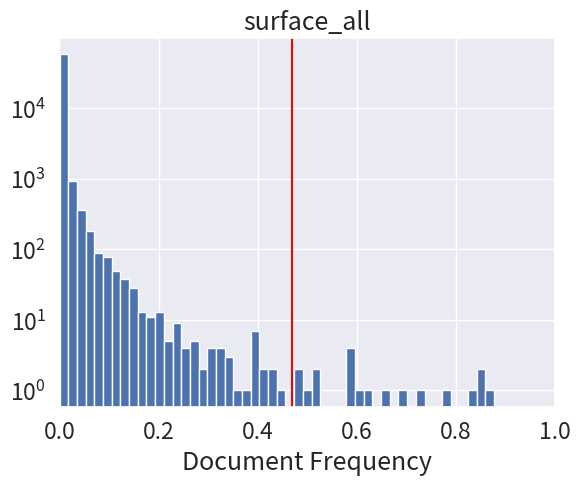

surface_taiyo: vocab=56092, nstop=10, rate=0.00018


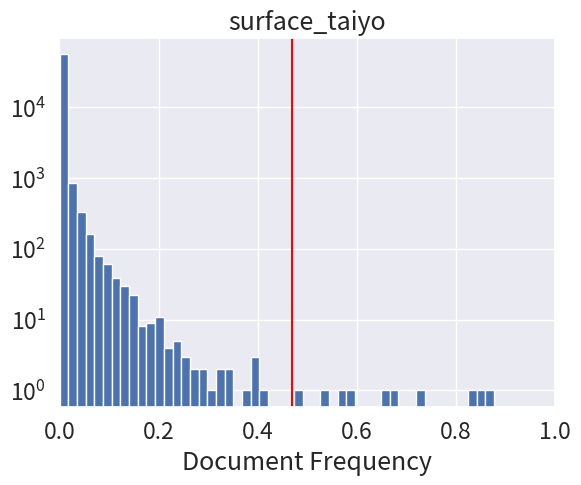

base_all: vocab=54447, nstop=18, rate=0.00033


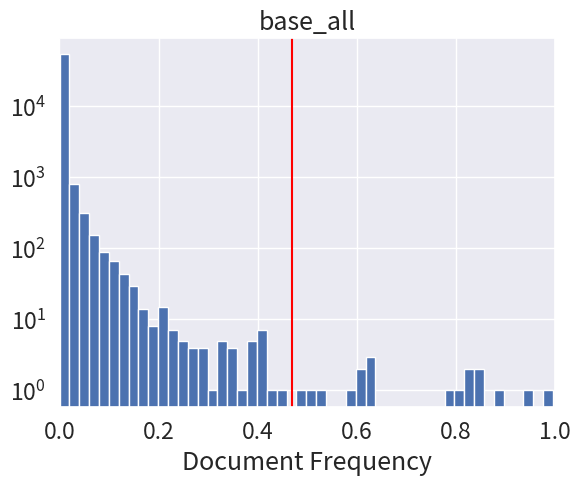

base_taiyo: vocab=51544, nstop=9, rate=0.00017


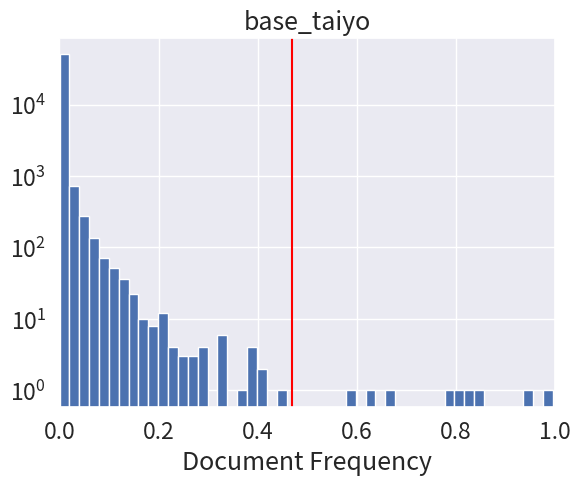

base_taigen: vocab=44484, nstop=1, rate=2e-05


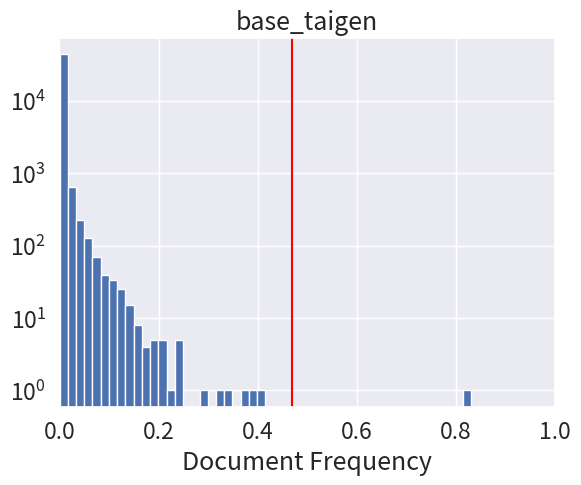

In [13]:
stopwords: Dict[str, List[str]] = dict()
for ctype, tfidf in tfidfs.items():
    df: np.ndarray = 1.0 / np.exp(tfidf.idf_ - 1)
    nvocab: int = len(tfidf.vocabulary_)
    nstop: int = np.where(df > df_threshold, 1, 0).sum()
    rate: float = round(nstop / nvocab, 5)
    print(f"{ctype}: vocab={nvocab}, nstop={nstop}, rate={rate}")
    id2word: Dict[int, str] = dict()
    for word, wid in tfidf.vocabulary_.items():
        id2word[wid] = word
    swds: List[str] = [id2word[x] for x in np.where(df > df_threshold)[0]]
    stopwords[ctype] = swds
    pd.Series(df).hist(bins=50, log=True)
    plt.axvline(df_threshold, color="red")
    plt.title(ctype)
    plt.xlabel("Document Frequency")
    plt.xlim(0, 1)
    plt.show()
    plt.clf()
    plt.close()

In [14]:
for ctype, sws in stopwords.items():
    print(ctype, sws)

surface_all ['ある', 'いう', 'いる', 'から', 'こと', 'この', 'する', 'その', 'できる', 'です', 'ない', 'なっ', 'など', 'なる', 'ます', 'まで', 'よう', 'より', 'れる']
surface_taiyo ['ある', 'いう', 'いる', 'こと', 'する', 'できる', 'ない', 'なっ', 'なる', 'よう']
base_all ['ある', 'いう', 'いる', 'から', 'こと', 'この', 'する', 'その', 'たい', 'できる', 'です', 'ない', 'など', 'なる', 'ます', 'まで', 'よう', 'れる']
base_taiyo ['ある', 'いう', 'いる', 'こと', 'する', 'できる', 'ない', 'なる', 'よう']
base_taigen ['こと']


In [15]:
def corpus2vectors(
    title: str,
    svs: Dict[str, Dict[str, np.ndarray]],
    cpus: Dict[str, str],
    pkvs: Dict[int, KeyedVectors],
    swds: List[str],
) -> None:
    for did, corpus in cpus.items():
        all_vec200 = np.zeros(200)
        all_vec300 = np.zeros(300)
        stop_vec200 = np.zeros(200)
        stop_vec300 = np.zeros(300)
        for word in corpus.split():
            is_stop: bool = word in swds
            try:
                v200: np.ndarray = pkvs[200].get_vector(word)
            except Exception:
                pass
            else:
                all_vec200 += v200
                if not is_stop:
                    stop_vec200 += v200
            try:
                v300: np.ndarray = pkvs[300].get_vector(word)
            except Exception:
                pass
            else:
                all_vec300 += v300
                if not is_stop:
                    stop_vec300 += v300
        all_vec200 /= np.clip(np.linalg.norm(all_vec200, ord=2), 1e-9, None)
        stop_vec200 /= np.clip(np.linalg.norm(stop_vec200, ord=2), 1e-9, None)
        all_vec300 /= np.clip(np.linalg.norm(all_vec300, ord=2), 1e-9, None)
        stop_vec300 /= np.clip(np.linalg.norm(stop_vec300, ord=2), 1e-9, None)
        svs[f"{title}_all_200"][did] = all_vec200
        svs[f"{title}_stop_200"][did] = stop_vec200
        svs[f"{title}_all_300"][did] = all_vec300
        svs[f"{title}_stop_300"][did] = stop_vec300
    return

In [16]:
story_vectors: Dict[str, Dict[str, np.ndarray]] = defaultdict(dict)

corpus2vectors(
    title="surface_all",
    svs=story_vectors,
    cpus=various_corpus["surface_all"],
    pkvs=kvs["surface"],
    swds=stopwords["surface_all"],
)
corpus2vectors(
    title="surface_taiyo",
    svs=story_vectors,
    cpus=various_corpus["surface_taiyo"],
    pkvs=kvs["surface"],
    swds=stopwords["surface_taiyo"],
)
corpus2vectors(
    title="base_all",
    svs=story_vectors,
    cpus=various_corpus["base_all"],
    pkvs=kvs["base"],
    swds=stopwords["base_all"],
)
corpus2vectors(
    title="base_taiyo",
    svs=story_vectors,
    cpus=various_corpus["base_taiyo"],
    pkvs=kvs["base"],
    swds=stopwords["base_taiyo"],
)
corpus2vectors(
    title="base_taigen",
    svs=story_vectors,
    cpus=various_corpus["base_taigen"],
    pkvs=kvs["base"],
    swds=stopwords["base_taigen"],
)

In [17]:
from sklearn.manifold import TSNE

planes: Dict[str, pd.DataFrame] = dict()
for ctype, dvecs in story_vectors.items():
    ovecs: np.ndarray = np.array(list(dvecs.values()))
    plane = TSNE(n_components=2, random_state=12, n_jobs=-1).fit_transform(
        ovecs
    )
    plane = pd.DataFrame(plane, columns=["x1", "x2"])
    plane = plane.assign(label=[x.label[0] for x in stories])
    planes[ctype] = plane

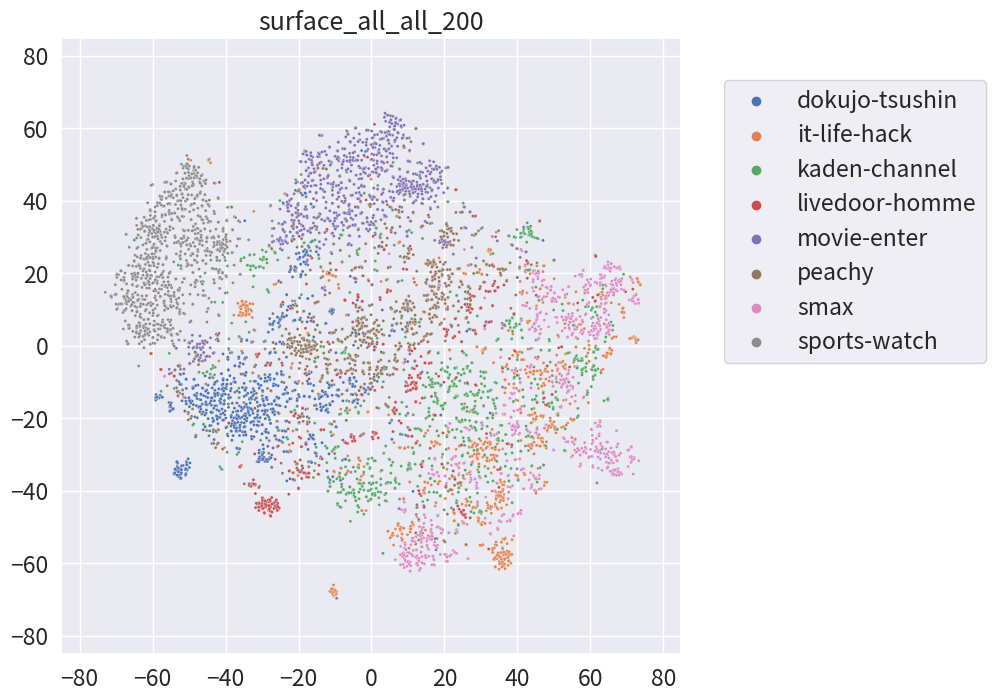

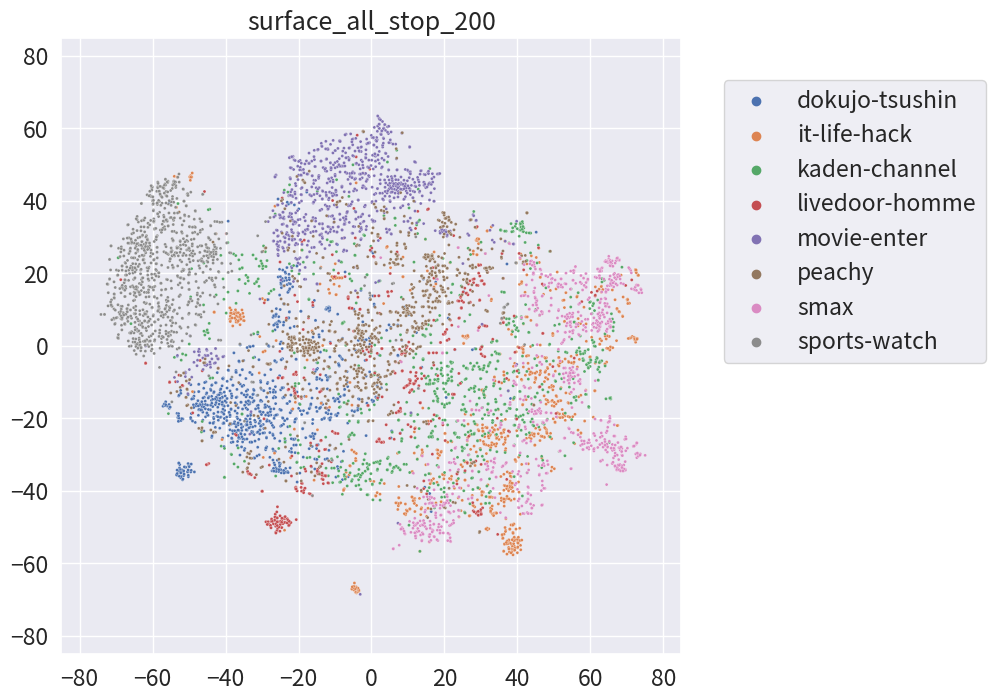

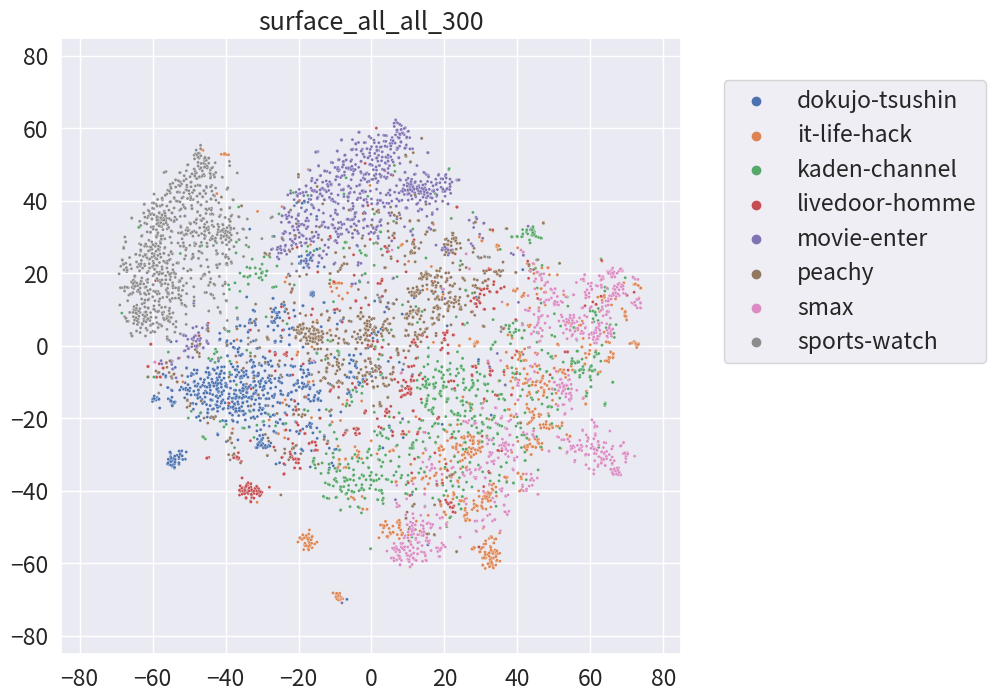

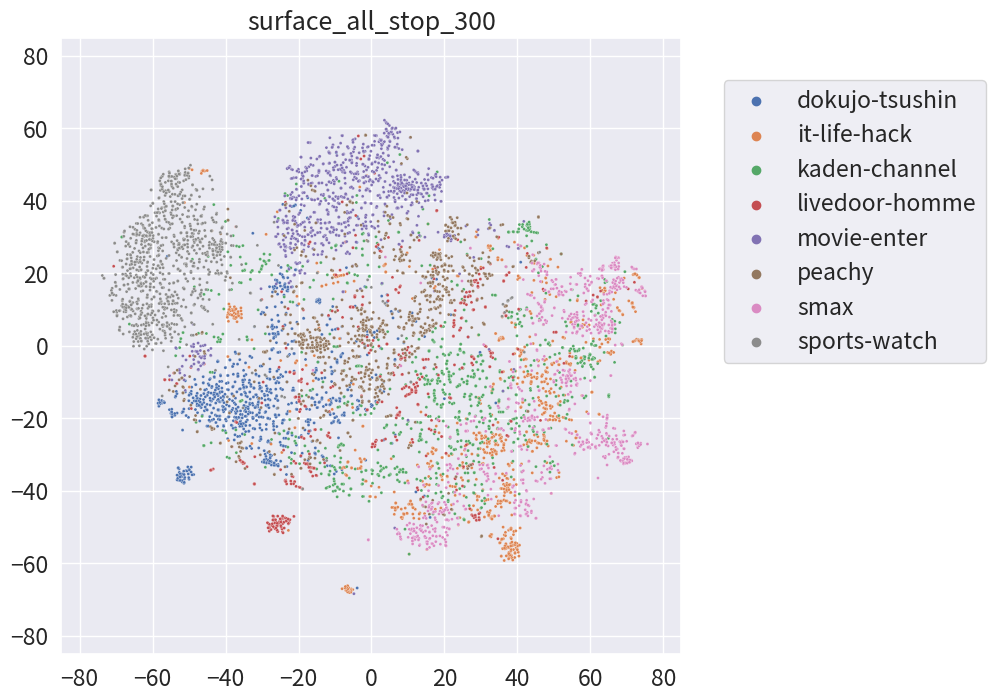

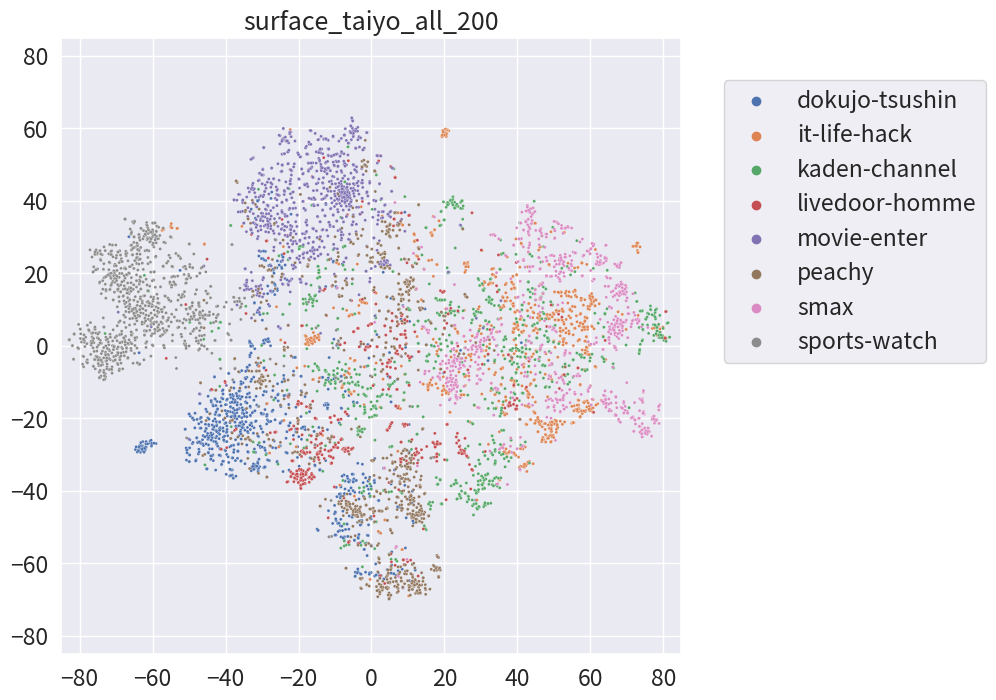

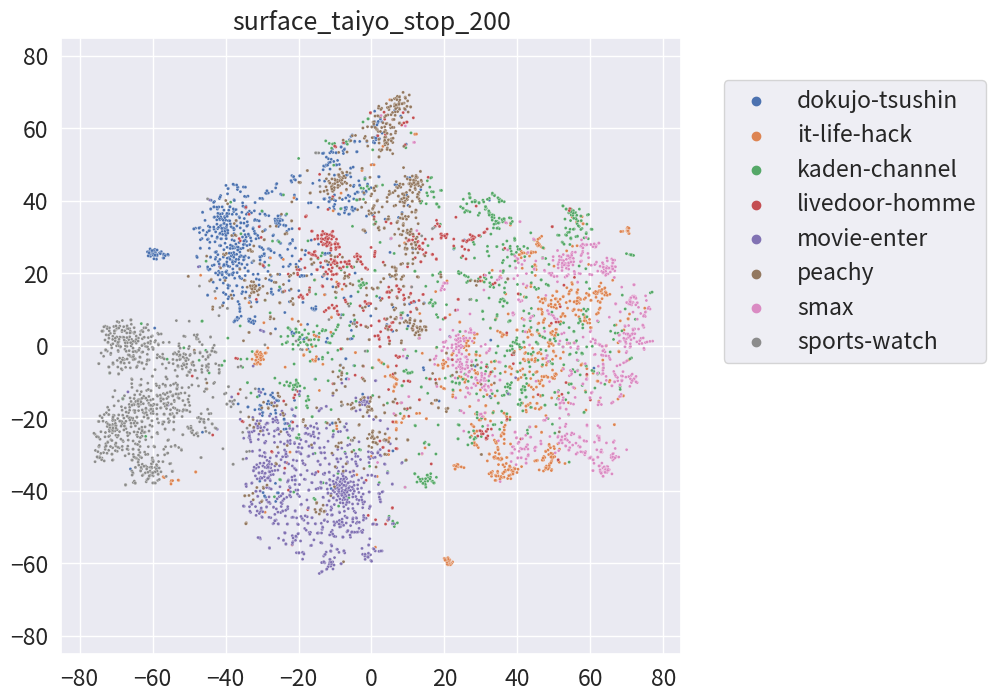

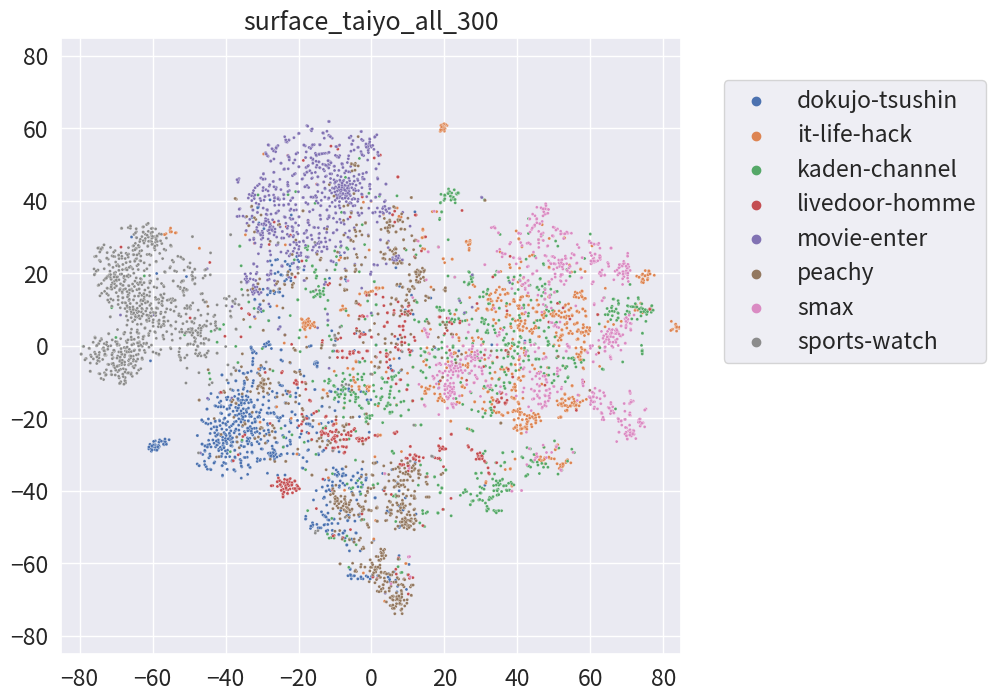

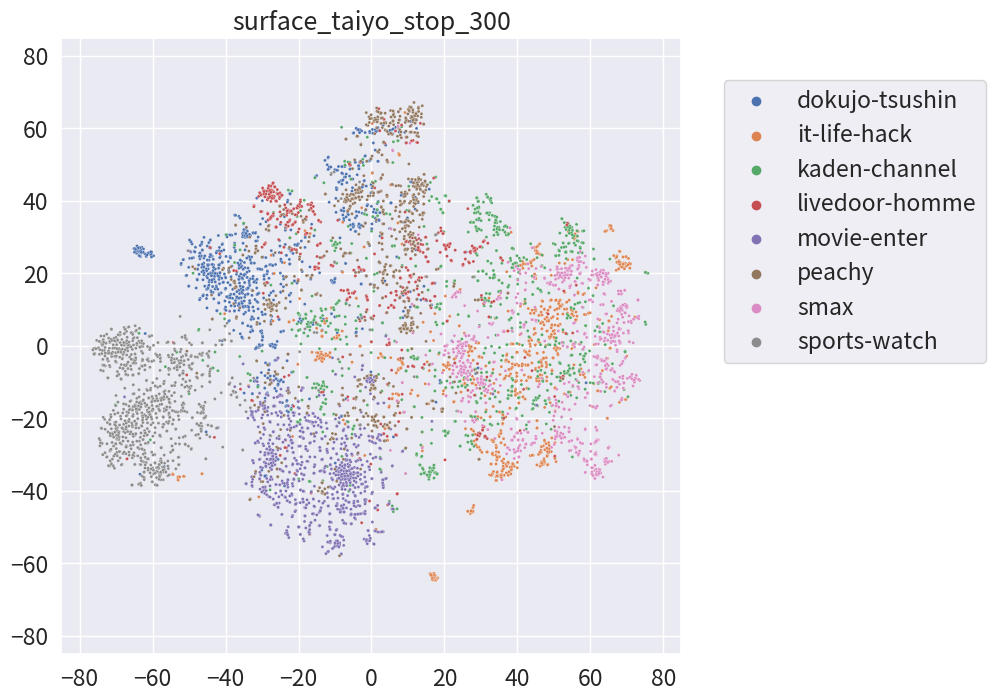

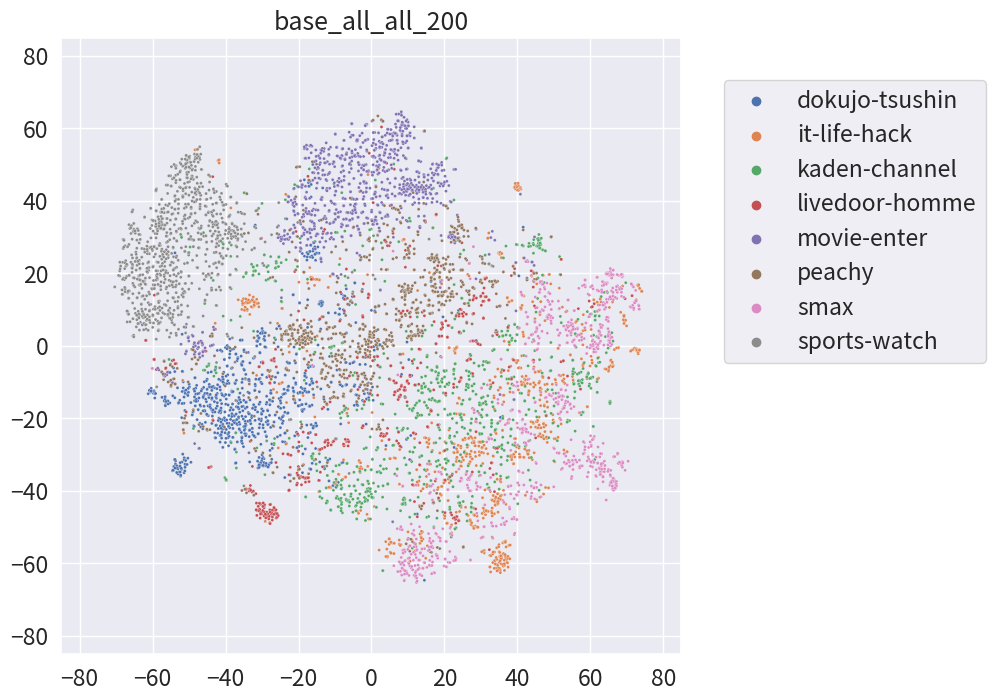

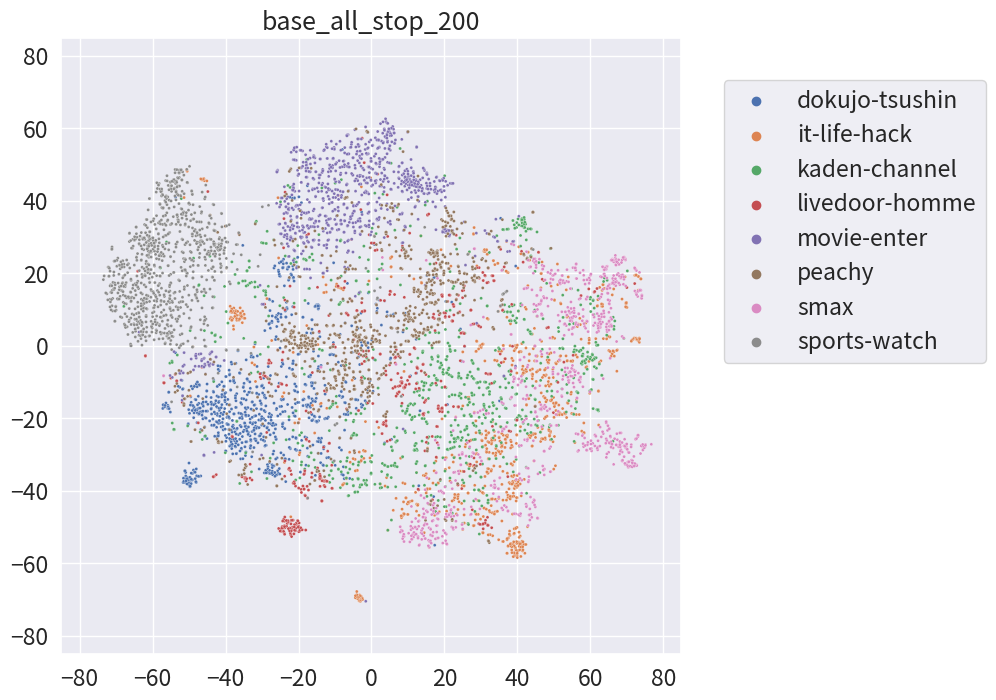

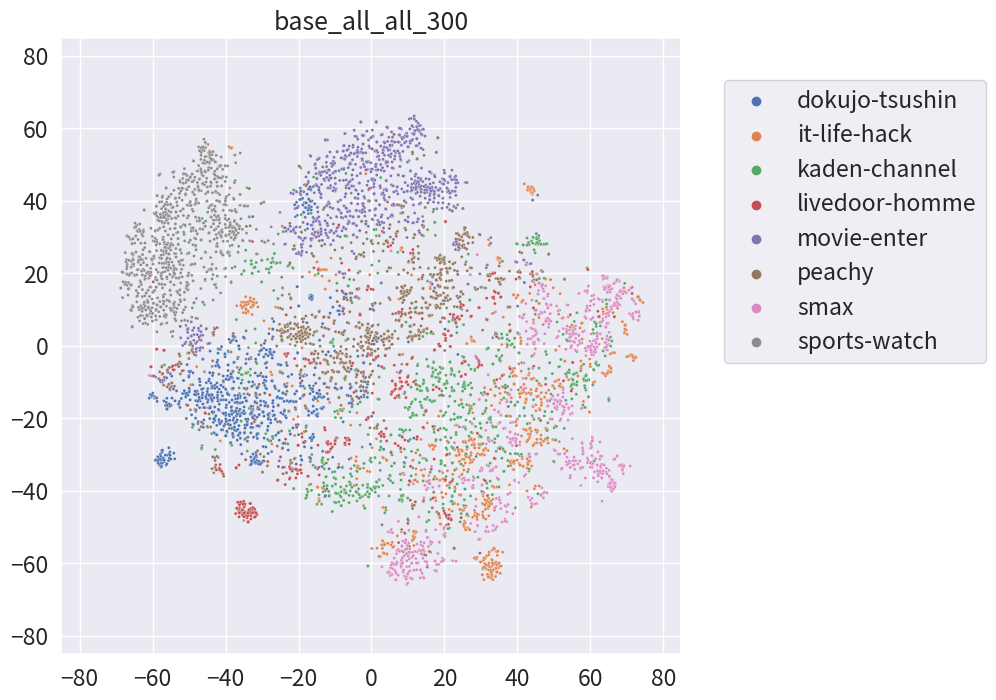

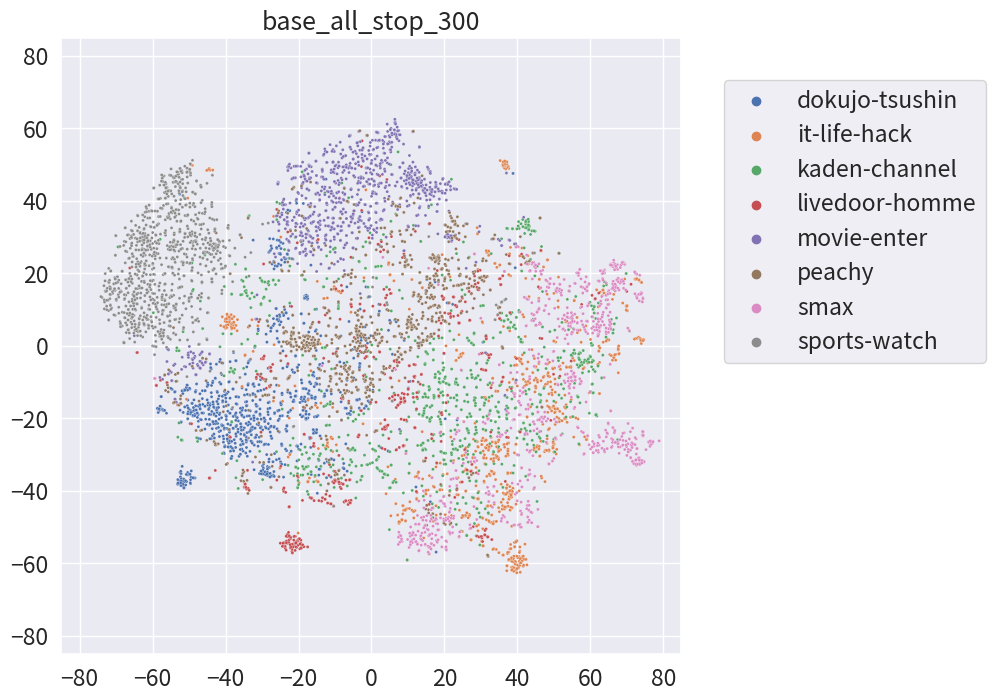

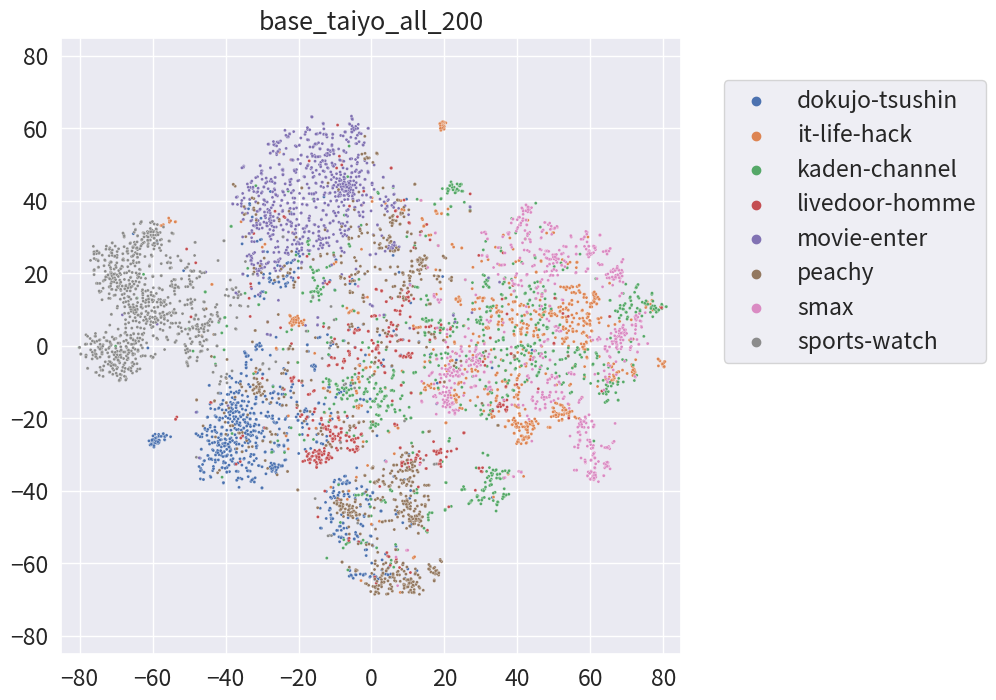

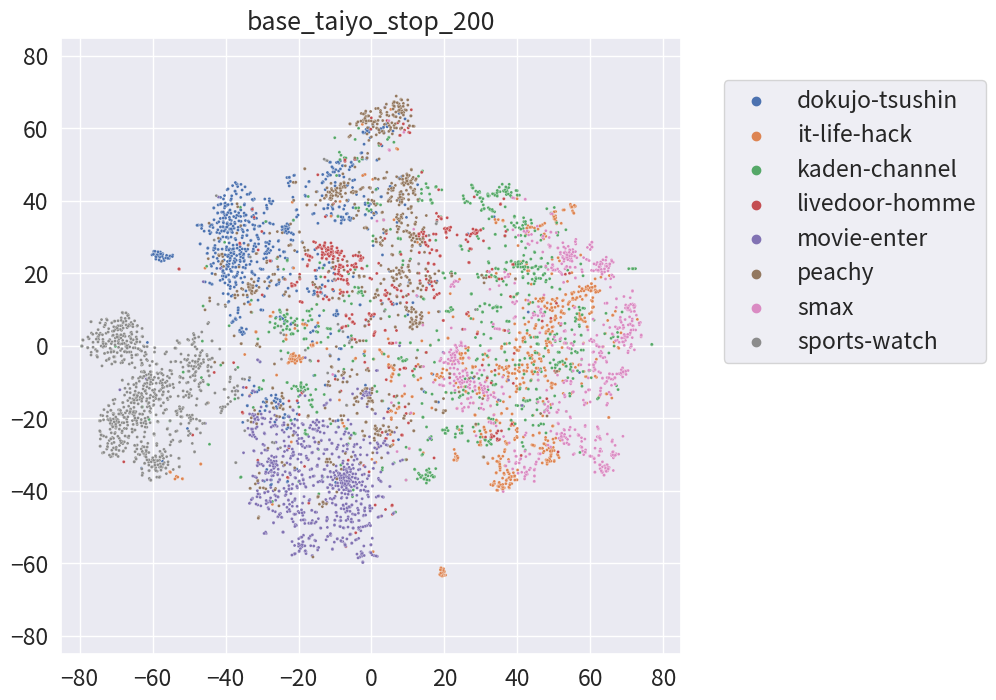

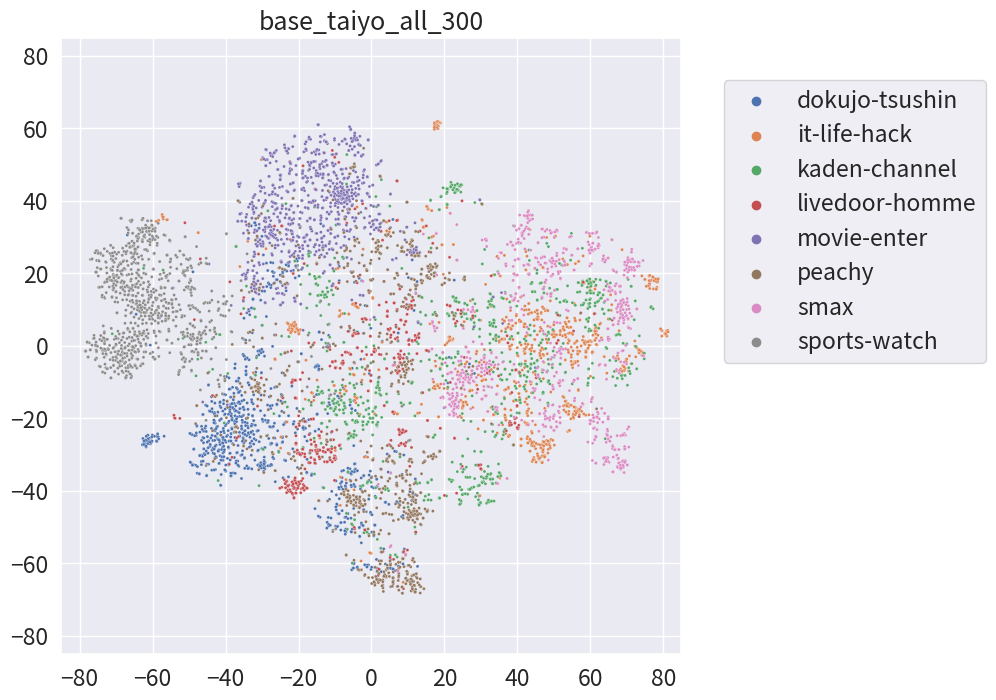

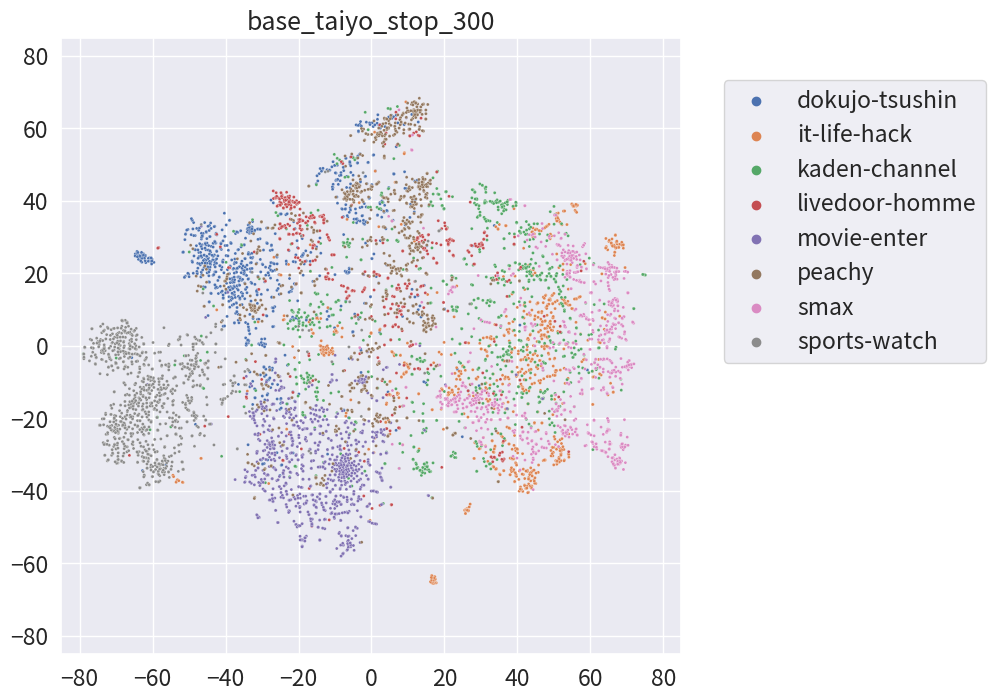

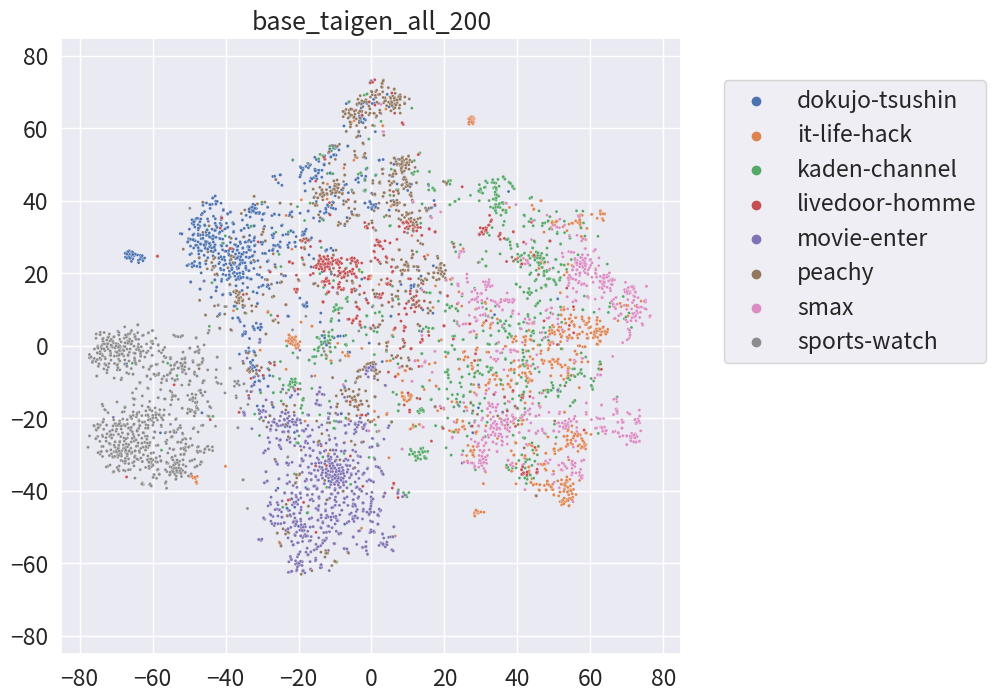

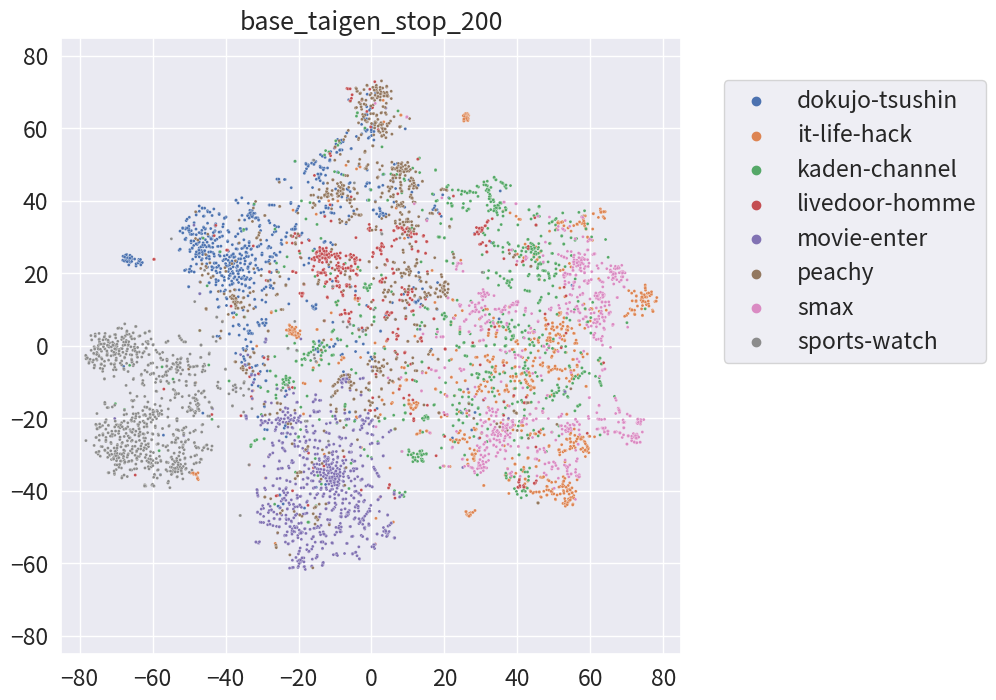

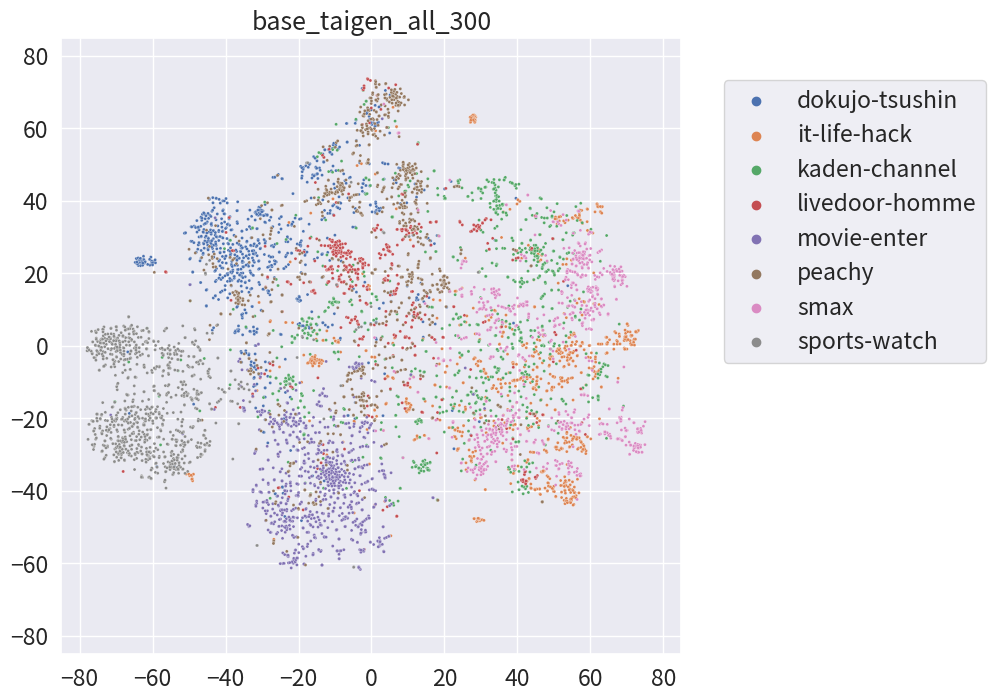

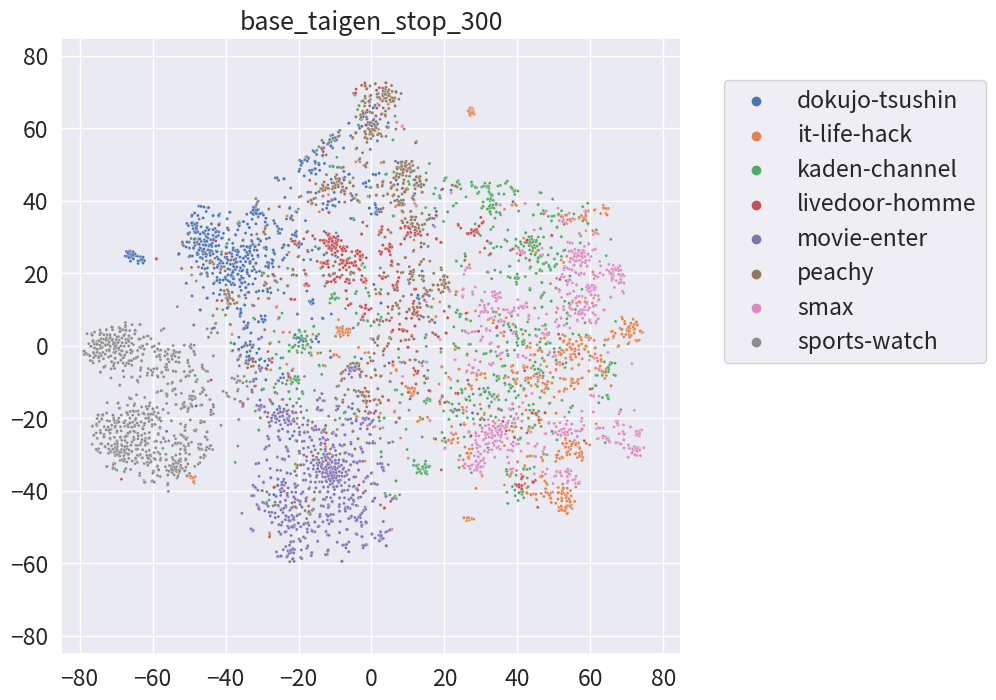

In [18]:
for ctype, plane in planes.items():
    fix, ax = plt.subplots(figsize=(8, 8))
    sns.scatterplot(data=plane, x="x1", y="x2", hue="label", s=5, ax=ax)
    plt.title(ctype)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.xlim(-85, 85)
    plt.ylim(-85, 85)
    plt.legend(bbox_to_anchor=(1.05, 0.95), loc="upper left")
    plt.show()
    plt.clf()
    plt.close()

In [19]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder().fit(
    list(set(sorted([x.label[0] for x in stories])))
)
label_encoder.classes_

array(['dokujo-tsushin', 'it-life-hack', 'kaden-channel',
       'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch'],
      dtype='<U14')

In [20]:
from sklearn.metrics import classification_report


def create_result_dataframe(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    labels: List[str],
    title: str,
    C: float,
) -> pd.DataFrame:
    result: pd.DataFrame = pd.DataFrame(
        classification_report(
            y_true,
            y_pred,
            target_names=labels,
            output_dict=True,
            zero_division=0,
        )
    ).loc[["f1-score"], labels]
    result = result.assign(average=result.mean(axis="columns"))
    result = result.assign(C=[C]).T
    result.columns = [title]
    return result

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC


results_train: List[pd.DataFrame] = list()
results_test: List[pd.DataFrame] = list()
results_all: List[pd.DataFrame] = list()
for ctype, dvecs in story_vectors.items():
    print(ctype)
    X: np.ndarray = np.array(list(dvecs.values()))
    y: np.ndarray = label_encoder.transform([x.label[0] for x in stories])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=True, stratify=y, random_state=12
    )
    param: Dict = {
        "C": [1],
    }
    svc: LinearSVC = LinearSVC(random_state=12)
    skf: StratifiedKFold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=12
    )
    scv: GridSearchCV = GridSearchCV(
        svc, param, cv=skf, scoring="f1_macro", refit=True, n_jobs=-1
    ).fit(X_train, y_train)
    pred_y_train = scv.best_estimator_.predict(X_train)
    result_train: pd.DataFrame = create_result_dataframe(
        y_true=y_train,
        y_pred=pred_y_train,
        labels=label_encoder.classes_.tolist(),
        title=ctype,
        C=scv.best_params_["C"],
    )
    results_train.append(result_train)
    pred_y_test = scv.best_estimator_.predict(X_test)
    result_test: pd.DataFrame = create_result_dataframe(
        y_true=y_test,
        y_pred=pred_y_test,
        labels=label_encoder.classes_.tolist(),
        title=ctype,
        C=scv.best_params_["C"],
    )
    results_test.append(result_test)
    pred_y = scv.best_estimator_.predict(X)
    result_all: pd.DataFrame = create_result_dataframe(
        y_true=y,
        y_pred=pred_y,
        labels=label_encoder.classes_.tolist(),
        title=ctype,
        C=scv.best_params_["C"],
    )
    results_all.append(result_all)

surface_all_all_200
surface_all_stop_200
surface_all_all_300
surface_all_stop_300
surface_taiyo_all_200
surface_taiyo_stop_200
surface_taiyo_all_300
surface_taiyo_stop_300
base_all_all_200
base_all_stop_200
base_all_all_300
base_all_stop_300
base_taiyo_all_200
base_taiyo_stop_200
base_taiyo_all_300
base_taiyo_stop_300
base_taigen_all_200
base_taigen_stop_200
base_taigen_all_300
base_taigen_stop_300


In [22]:
show_it(pd.concat(results_train, axis=1))

|                |   surface_all_all_200 |   surface_all_stop_200 |   surface_all_all_300 |   surface_all_stop_300 |   surface_taiyo_all_200 |   surface_taiyo_stop_200 |   surface_taiyo_all_300 |   surface_taiyo_stop_300 |   base_all_all_200 |   base_all_stop_200 |   base_all_all_300 |   base_all_stop_300 |   base_taiyo_all_200 |   base_taiyo_stop_200 |   base_taiyo_all_300 |   base_taiyo_stop_300 |   base_taigen_all_200 |   base_taigen_stop_200 |   base_taigen_all_300 |   base_taigen_stop_300 |
|:---------------|----------------------:|-----------------------:|----------------------:|-----------------------:|------------------------:|-------------------------:|------------------------:|-------------------------:|-------------------:|--------------------:|-------------------:|--------------------:|---------------------:|----------------------:|---------------------:|----------------------:|----------------------:|-----------------------:|----------------------:|-----------------------:|
| dokujo-tsushin |                0.8238 |                 0.8202 |                0.8288 |                 0.8206 |                  0.8063 |                   0.8060 |                  0.8183 |                   0.8184 |             0.8110 |              0.8080 |             0.8156 |              0.8153 |               0.7934 |                0.8099 |               0.8145 |                0.8273 |                0.8248 |                 0.8283 |                0.8433 |                 0.8449 |
| it-life-hack   |                0.7800 |                 0.7762 |                0.8179 |                 0.8222 |                  0.8178 |                   0.8060 |                  0.8412 |                   0.8397 |             0.7794 |              0.7939 |             0.8132 |              0.8178 |               0.8084 |                0.8081 |               0.8339 |                0.8375 |                0.8081 |                 0.8087 |                0.8315 |                 0.8421 |
| kaden-channel  |                0.7605 |                 0.7563 |                0.7784 |                 0.7812 |                  0.7728 |                   0.7625 |                  0.7907 |                   0.7914 |             0.7336 |              0.7370 |             0.7603 |              0.7691 |               0.7708 |                0.7662 |               0.7962 |                0.8007 |                0.7666 |                 0.7650 |                0.7983 |                 0.8084 |
| livedoor-homme |                0.6299 |                 0.6341 |                0.6597 |                 0.6493 |                  0.7387 |                   0.7539 |                  0.7555 |                   0.7640 |             0.6299 |              0.6232 |             0.6445 |              0.6425 |               0.7196 |                0.7287 |               0.7524 |                0.7652 |                0.7347 |                 0.7360 |                0.7578 |                 0.7621 |
| movie-enter    |                0.9026 |                 0.8998 |                0.9050 |                 0.9044 |                  0.9153 |                   0.9153 |                  0.9210 |                   0.9250 |             0.9072 |              0.9022 |             0.9029 |              0.9029 |               0.9143 |                0.9161 |               0.9239 |                0.9219 |                0.9169 |                 0.9156 |                0.9243 |                 0.9257 |
| peachy         |                0.7771 |                 0.7609 |                0.7900 |                 0.7719 |                  0.7676 |                   0.7618 |                  0.7845 |                   0.7805 |             0.7688 |              0.7363 |             0.7830 |              0.7528 |               0.7484 |                0.7606 |               0.7729 |                0.7804 |                0.7580 |                 0.7661 |                0.7899 |                 0.7816 |
| smax           |                0.8853 |                 0.8759 |                0.9091 |                 0.8885 |                  0.8845 |                   0.8836 |                  0.9056 |                   0.9039 |             0.8796 |              0.8675 |             0.9013 |              0.8811 |               0.8786 |                0.8828 |               0.8952 |                0.8949 |                0.8866 |                 0.8877 |                0.8945 |                 0.8959 |
| sports-watch   |                0.9577 |                 0.9562 |                0.9607 |                 0.9608 |                  0.9666 |                   0.9682 |                  0.9713 |                   0.9721 |             0.9564 |              0.9542 |             0.9593 |              0.9601 |               0.9658 |                0.9674 |               0.9698 |                0.9729 |                0.9690 |                 0.9697 |                0.9752 |                 0.9728 |
| average        |                0.8146 |                 0.8099 |                0.8312 |                 0.8249 |                  0.8337 |                   0.8322 |                  0.8485 |                   0.8494 |             0.8082 |              0.8028 |             0.8225 |              0.8177 |               0.8249 |                0.8300 |               0.8448 |                0.8501 |                0.8331 |                 0.8346 |                0.8518 |                 0.8542 |
| C              |                1.0000 |                 1.0000 |                1.0000 |                 1.0000 |                  1.0000 |                   1.0000 |                  1.0000 |                   1.0000 |             1.0000 |              1.0000 |             1.0000 |              1.0000 |               1.0000 |                1.0000 |               1.0000 |                1.0000 |                1.0000 |                 1.0000 |                1.0000 |                 1.0000 |

In [23]:
show_it(pd.concat(results_train, axis=1).T.loc[:, ["average", "C"]])

|                        |   average |      C |
|:-----------------------|----------:|-------:|
| surface_all_all_200    |    0.8146 | 1.0000 |
| surface_all_stop_200   |    0.8099 | 1.0000 |
| surface_all_all_300    |    0.8312 | 1.0000 |
| surface_all_stop_300   |    0.8249 | 1.0000 |
| surface_taiyo_all_200  |    0.8337 | 1.0000 |
| surface_taiyo_stop_200 |    0.8322 | 1.0000 |
| surface_taiyo_all_300  |    0.8485 | 1.0000 |
| surface_taiyo_stop_300 |    0.8494 | 1.0000 |
| base_all_all_200       |    0.8082 | 1.0000 |
| base_all_stop_200      |    0.8028 | 1.0000 |
| base_all_all_300       |    0.8225 | 1.0000 |
| base_all_stop_300      |    0.8177 | 1.0000 |
| base_taiyo_all_200     |    0.8249 | 1.0000 |
| base_taiyo_stop_200    |    0.8300 | 1.0000 |
| base_taiyo_all_300     |    0.8448 | 1.0000 |
| base_taiyo_stop_300    |    0.8501 | 1.0000 |
| base_taigen_all_200    |    0.8331 | 1.0000 |
| base_taigen_stop_200   |    0.8346 | 1.0000 |
| base_taigen_all_300    |    0.8518 | 1.0000 |
| base_taigen_stop_300   |    0.8542 | 1.0000 |

In [24]:
show_it(pd.concat(results_test, axis=1))

|                |   surface_all_all_200 |   surface_all_stop_200 |   surface_all_all_300 |   surface_all_stop_300 |   surface_taiyo_all_200 |   surface_taiyo_stop_200 |   surface_taiyo_all_300 |   surface_taiyo_stop_300 |   base_all_all_200 |   base_all_stop_200 |   base_all_all_300 |   base_all_stop_300 |   base_taiyo_all_200 |   base_taiyo_stop_200 |   base_taiyo_all_300 |   base_taiyo_stop_300 |   base_taigen_all_200 |   base_taigen_stop_200 |   base_taigen_all_300 |   base_taigen_stop_300 |
|:---------------|----------------------:|-----------------------:|----------------------:|-----------------------:|------------------------:|-------------------------:|------------------------:|-------------------------:|-------------------:|--------------------:|-------------------:|--------------------:|---------------------:|----------------------:|---------------------:|----------------------:|----------------------:|-----------------------:|----------------------:|-----------------------:|
| dokujo-tsushin |                0.8175 |                 0.8101 |                0.8197 |                 0.8159 |                  0.8008 |                   0.7962 |                  0.8129 |                   0.8175 |             0.8065 |              0.8102 |             0.8108 |              0.8058 |               0.7903 |                0.8053 |               0.8083 |                0.8253 |                0.8170 |                 0.8147 |                0.8208 |                 0.8194 |
| it-life-hack   |                0.7828 |                 0.7797 |                0.8039 |                 0.8109 |                  0.8157 |                   0.8054 |                  0.8311 |                   0.8233 |             0.7868 |              0.7782 |             0.8145 |              0.7922 |               0.8233 |                0.8062 |               0.8164 |                0.8245 |                0.8093 |                 0.8077 |                0.8196 |                 0.8242 |
| kaden-channel  |                0.7500 |                 0.7553 |                0.7673 |                 0.7753 |                  0.7743 |                   0.7699 |                  0.7810 |                   0.7859 |             0.7443 |              0.7179 |             0.7598 |              0.7505 |               0.7778 |                0.7648 |               0.7876 |                0.7918 |                0.7459 |                 0.7526 |                0.7708 |                 0.7724 |
| livedoor-homme |                0.5975 |                 0.5975 |                0.6250 |                 0.6050 |                  0.7092 |                   0.7046 |                  0.7138 |                   0.7148 |             0.6025 |              0.6058 |             0.6017 |              0.6050 |               0.6738 |                0.6950 |               0.7108 |                0.7241 |                0.7148 |                 0.7153 |                0.7347 |                 0.7322 |
| movie-enter    |                0.8743 |                 0.8775 |                0.8824 |                 0.8848 |                  0.8768 |                   0.8813 |                  0.8877 |                   0.8937 |             0.8759 |              0.8764 |             0.8791 |              0.8820 |               0.8829 |                0.8817 |               0.8901 |                0.8873 |                0.8801 |                 0.8797 |                0.8837 |                 0.8806 |
| peachy         |                0.7453 |                 0.7239 |                0.7575 |                 0.7345 |                  0.7255 |                   0.7146 |                  0.7412 |                   0.7258 |             0.7314 |              0.7188 |             0.7410 |              0.7208 |               0.7255 |                0.7294 |               0.7298 |                0.7416 |                0.7276 |                 0.7248 |                0.7475 |                 0.7421 |
| smax           |                0.8725 |                 0.8727 |                0.8922 |                 0.8901 |                  0.8613 |                   0.8734 |                  0.8725 |                   0.8782 |             0.8725 |              0.8587 |             0.8827 |              0.8739 |               0.8625 |                0.8641 |               0.8635 |                0.8757 |                0.8651 |                 0.8678 |                0.8810 |                 0.8790 |
| sports-watch   |                0.9635 |                 0.9707 |                0.9672 |                 0.9707 |                  0.9635 |                   0.9670 |                  0.9670 |                   0.9687 |             0.9601 |              0.9636 |             0.9689 |              0.9707 |               0.9650 |                0.9669 |               0.9651 |                0.9653 |                0.9651 |                 0.9634 |                0.9669 |                 0.9706 |
| average        |                0.8004 |                 0.7984 |                0.8144 |                 0.8109 |                  0.8159 |                   0.8140 |                  0.8259 |                   0.8260 |             0.7975 |              0.7912 |             0.8073 |              0.8001 |               0.8126 |                0.8142 |               0.8215 |                0.8295 |                0.8156 |                 0.8157 |                0.8281 |                 0.8275 |
| C              |                1.0000 |                 1.0000 |                1.0000 |                 1.0000 |                  1.0000 |                   1.0000 |                  1.0000 |                   1.0000 |             1.0000 |              1.0000 |             1.0000 |              1.0000 |               1.0000 |                1.0000 |               1.0000 |                1.0000 |                1.0000 |                 1.0000 |                1.0000 |                 1.0000 |

In [25]:
show_it(pd.concat(results_test, axis=1).T.loc[:, ["average", "C"]])

|                        |   average |      C |
|:-----------------------|----------:|-------:|
| surface_all_all_200    |    0.8004 | 1.0000 |
| surface_all_stop_200   |    0.7984 | 1.0000 |
| surface_all_all_300    |    0.8144 | 1.0000 |
| surface_all_stop_300   |    0.8109 | 1.0000 |
| surface_taiyo_all_200  |    0.8159 | 1.0000 |
| surface_taiyo_stop_200 |    0.8140 | 1.0000 |
| surface_taiyo_all_300  |    0.8259 | 1.0000 |
| surface_taiyo_stop_300 |    0.8260 | 1.0000 |
| base_all_all_200       |    0.7975 | 1.0000 |
| base_all_stop_200      |    0.7912 | 1.0000 |
| base_all_all_300       |    0.8073 | 1.0000 |
| base_all_stop_300      |    0.8001 | 1.0000 |
| base_taiyo_all_200     |    0.8126 | 1.0000 |
| base_taiyo_stop_200    |    0.8142 | 1.0000 |
| base_taiyo_all_300     |    0.8215 | 1.0000 |
| base_taiyo_stop_300    |    0.8295 | 1.0000 |
| base_taigen_all_200    |    0.8156 | 1.0000 |
| base_taigen_stop_200   |    0.8157 | 1.0000 |
| base_taigen_all_300    |    0.8281 | 1.0000 |
| base_taigen_stop_300   |    0.8275 | 1.0000 |

In [26]:
show_it(pd.concat(results_all, axis=1))

|                |   surface_all_all_200 |   surface_all_stop_200 |   surface_all_all_300 |   surface_all_stop_300 |   surface_taiyo_all_200 |   surface_taiyo_stop_200 |   surface_taiyo_all_300 |   surface_taiyo_stop_300 |   base_all_all_200 |   base_all_stop_200 |   base_all_all_300 |   base_all_stop_300 |   base_taiyo_all_200 |   base_taiyo_stop_200 |   base_taiyo_all_300 |   base_taiyo_stop_300 |   base_taigen_all_200 |   base_taigen_stop_200 |   base_taigen_all_300 |   base_taigen_stop_300 |
|:---------------|----------------------:|-----------------------:|----------------------:|-----------------------:|------------------------:|-------------------------:|------------------------:|-------------------------:|-------------------:|--------------------:|-------------------:|--------------------:|---------------------:|----------------------:|---------------------:|----------------------:|----------------------:|-----------------------:|----------------------:|-----------------------:|
| dokujo-tsushin |                0.8219 |                 0.8171 |                0.8261 |                 0.8192 |                  0.8047 |                   0.8031 |                  0.8167 |                   0.8181 |             0.8096 |              0.8086 |             0.8142 |              0.8124 |               0.7925 |                0.8085 |               0.8127 |                0.8267 |                0.8225 |                 0.8243 |                0.8367 |                 0.8374 |
| it-life-hack   |                0.7808 |                 0.7773 |                0.8136 |                 0.8188 |                  0.8172 |                   0.8058 |                  0.8382 |                   0.8348 |             0.7816 |              0.7892 |             0.8136 |              0.8100 |               0.8129 |                0.8075 |               0.8286 |                0.8336 |                0.8085 |                 0.8084 |                0.8279 |                 0.8367 |
| kaden-channel  |                0.7574 |                 0.7560 |                0.7752 |                 0.7795 |                  0.7733 |                   0.7646 |                  0.7879 |                   0.7898 |             0.7368 |              0.7314 |             0.7602 |              0.7636 |               0.7729 |                0.7658 |               0.7937 |                0.7981 |                0.7605 |                 0.7613 |                0.7902 |                 0.7979 |
| livedoor-homme |                0.6202 |                 0.6233 |                0.6495 |                 0.6364 |                  0.7296 |                   0.7389 |                  0.7427 |                   0.7487 |             0.6217 |              0.6180 |             0.6320 |              0.6316 |               0.7058 |                0.7184 |               0.7395 |                0.7524 |                0.7284 |                 0.7296 |                0.7505 |                 0.7527 |
| movie-enter    |                0.8942 |                 0.8932 |                0.8982 |                 0.8986 |                  0.9038 |                   0.9050 |                  0.9110 |                   0.9155 |             0.8979 |              0.8945 |             0.8958 |              0.8966 |               0.9048 |                0.9057 |               0.9137 |                0.9114 |                0.9057 |                 0.9048 |                0.9120 |                 0.9120 |
| peachy         |                0.7672 |                 0.7493 |                0.7797 |                 0.7602 |                  0.7544 |                   0.7469 |                  0.7710 |                   0.7636 |             0.7571 |              0.7308 |             0.7698 |              0.7428 |               0.7413 |                0.7509 |               0.7596 |                0.7684 |                0.7486 |                 0.7534 |                0.7770 |                 0.7696 |
| smax           |                0.8815 |                 0.8749 |                0.9041 |                 0.8890 |                  0.8775 |                   0.8806 |                  0.8957 |                   0.8962 |             0.8775 |              0.8649 |             0.8958 |              0.8790 |               0.8738 |                0.8772 |               0.8857 |                0.8891 |                0.8802 |                 0.8818 |                0.8905 |                 0.8909 |
| sports-watch   |                0.9594 |                 0.9605 |                0.9626 |                 0.9637 |                  0.9657 |                   0.9679 |                  0.9700 |                   0.9711 |             0.9575 |              0.9570 |             0.9622 |              0.9632 |               0.9656 |                0.9673 |               0.9684 |                0.9706 |                0.9678 |                 0.9678 |                0.9727 |                 0.9722 |
| average        |                0.8103 |                 0.8065 |                0.8261 |                 0.8207 |                  0.8283 |                   0.8266 |                  0.8416 |                   0.8422 |             0.8050 |              0.7993 |             0.8179 |              0.8124 |               0.8212 |                0.8252 |               0.8377 |                0.8438 |                0.8278 |                 0.8289 |                0.8447 |                 0.8462 |
| C              |                1.0000 |                 1.0000 |                1.0000 |                 1.0000 |                  1.0000 |                   1.0000 |                  1.0000 |                   1.0000 |             1.0000 |              1.0000 |             1.0000 |              1.0000 |               1.0000 |                1.0000 |               1.0000 |                1.0000 |                1.0000 |                 1.0000 |                1.0000 |                 1.0000 |

In [27]:
show_it(pd.concat(results_all, axis=1).T.loc[:, ["average", "C"]])

|                        |   average |      C |
|:-----------------------|----------:|-------:|
| surface_all_all_200    |    0.8103 | 1.0000 |
| surface_all_stop_200   |    0.8065 | 1.0000 |
| surface_all_all_300    |    0.8261 | 1.0000 |
| surface_all_stop_300   |    0.8207 | 1.0000 |
| surface_taiyo_all_200  |    0.8283 | 1.0000 |
| surface_taiyo_stop_200 |    0.8266 | 1.0000 |
| surface_taiyo_all_300  |    0.8416 | 1.0000 |
| surface_taiyo_stop_300 |    0.8422 | 1.0000 |
| base_all_all_200       |    0.8050 | 1.0000 |
| base_all_stop_200      |    0.7993 | 1.0000 |
| base_all_all_300       |    0.8179 | 1.0000 |
| base_all_stop_300      |    0.8124 | 1.0000 |
| base_taiyo_all_200     |    0.8212 | 1.0000 |
| base_taiyo_stop_200    |    0.8252 | 1.0000 |
| base_taiyo_all_300     |    0.8377 | 1.0000 |
| base_taiyo_stop_300    |    0.8438 | 1.0000 |
| base_taigen_all_200    |    0.8278 | 1.0000 |
| base_taigen_stop_200   |    0.8289 | 1.0000 |
| base_taigen_all_300    |    0.8447 | 1.0000 |
| base_taigen_stop_300   |    0.8462 | 1.0000 |

In [28]:
results_scores = pd.concat(
    [
        pd.concat(results_train, axis=1).T.loc[:, ["average"]],
        pd.concat(results_test, axis=1).T.loc[:, ["average"]],
        (
            pd.concat(results_train, axis=1).T.loc[:, ["average"]]
            - pd.concat(results_test, axis=1).T.loc[:, ["average"]]
        ),
        pd.concat(results_all, axis=1).T.loc[:, ["average"]],
    ],
    axis=1,
)
results_scores.columns = ["test", "train", "diff", "all"]
patterns = dict()
ctypes = list(results_scores.index)
for ctype in ctypes:
    pats = ctype.split("_")
    patterns[ctype] = {
        "変化形": pats[0],
        "品詞": pats[1],
        "STOP WORD": pats[2],
        "ベクトル次元": int(pats[3]),
    }
results_scores = pd.concat(
    [
        pd.DataFrame(patterns).T,
        results_scores,
    ],
    axis=1,
)
show_it(results_scores)

|                        | 変化形   | 品詞   | STOP WORD   |   ベクトル次元 |   test |   train |   diff |    all |
|:-----------------------|:---------|:-------|:------------|---------------:|-------:|--------:|-------:|-------:|
| surface_all_all_200    | surface  | all    | all         |            200 | 0.8146 |  0.8004 | 0.0142 | 0.8103 |
| surface_all_stop_200   | surface  | all    | stop        |            200 | 0.8099 |  0.7984 | 0.0115 | 0.8065 |
| surface_all_all_300    | surface  | all    | all         |            300 | 0.8312 |  0.8144 | 0.0168 | 0.8261 |
| surface_all_stop_300   | surface  | all    | stop        |            300 | 0.8249 |  0.8109 | 0.0140 | 0.8207 |
| surface_taiyo_all_200  | surface  | taiyo  | all         |            200 | 0.8337 |  0.8159 | 0.0178 | 0.8283 |
| surface_taiyo_stop_200 | surface  | taiyo  | stop        |            200 | 0.8322 |  0.8140 | 0.0181 | 0.8266 |
| surface_taiyo_all_300  | surface  | taiyo  | all         |            300 | 0.8485 |  0.8259 | 0.0226 | 0.8416 |
| surface_taiyo_stop_300 | surface  | taiyo  | stop        |            300 | 0.8494 |  0.8260 | 0.0234 | 0.8422 |
| base_all_all_200       | base     | all    | all         |            200 | 0.8082 |  0.7975 | 0.0107 | 0.8050 |
| base_all_stop_200      | base     | all    | stop        |            200 | 0.8028 |  0.7912 | 0.0116 | 0.7993 |
| base_all_all_300       | base     | all    | all         |            300 | 0.8225 |  0.8073 | 0.0152 | 0.8179 |
| base_all_stop_300      | base     | all    | stop        |            300 | 0.8177 |  0.8001 | 0.0176 | 0.8124 |
| base_taiyo_all_200     | base     | taiyo  | all         |            200 | 0.8249 |  0.8126 | 0.0123 | 0.8212 |
| base_taiyo_stop_200    | base     | taiyo  | stop        |            200 | 0.8300 |  0.8142 | 0.0158 | 0.8252 |
| base_taiyo_all_300     | base     | taiyo  | all         |            300 | 0.8448 |  0.8215 | 0.0234 | 0.8377 |
| base_taiyo_stop_300    | base     | taiyo  | stop        |            300 | 0.8501 |  0.8295 | 0.0206 | 0.8438 |
| base_taigen_all_200    | base     | taigen | all         |            200 | 0.8331 |  0.8156 | 0.0175 | 0.8278 |
| base_taigen_stop_200   | base     | taigen | stop        |            200 | 0.8346 |  0.8157 | 0.0189 | 0.8289 |
| base_taigen_all_300    | base     | taigen | all         |            300 | 0.8518 |  0.8281 | 0.0237 | 0.8447 |
| base_taigen_stop_300   | base     | taigen | stop        |            300 | 0.8542 |  0.8275 | 0.0267 | 0.8462 |

In [29]:
results_train2: List[pd.DataFrame] = list()
results_test2: List[pd.DataFrame] = list()
results_all2: List[pd.DataFrame] = list()
for ctype, dvecs in story_vectors.items():
    print(ctype)
    X: np.ndarray = np.array(list(dvecs.values()))
    y: np.ndarray = label_encoder.transform([x.label[0] for x in stories])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=True, stratify=y, random_state=12
    )
    param: Dict = {
        "C": [1, 3, 5, 8, 10, 30, 50, 80, 100],
    }
    svc: LinearSVC = LinearSVC(max_iter=10000, random_state=12)
    skf: StratifiedKFold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=12
    )
    scv: GridSearchCV = GridSearchCV(
        svc,
        param,
        cv=skf,
        scoring="f1_macro",
        refit=True,
        n_jobs=-1,
    ).fit(X_train, y_train)
    pred_y_train = scv.best_estimator_.predict(X_train)
    result_train: pd.DataFrame = create_result_dataframe(
        y_true=y_train,
        y_pred=pred_y_train,
        labels=label_encoder.classes_.tolist(),
        title=ctype,
        C=scv.best_params_["C"],
    )
    results_train2.append(result_train)
    pred_y_test = scv.best_estimator_.predict(X_test)
    result_test: pd.DataFrame = create_result_dataframe(
        y_true=y_test,
        y_pred=pred_y_test,
        labels=label_encoder.classes_.tolist(),
        title=ctype,
        C=scv.best_params_["C"],
    )
    results_test2.append(result_test)
    pred_y = scv.best_estimator_.predict(X)
    result_all: pd.DataFrame = create_result_dataframe(
        y_true=y,
        y_pred=pred_y,
        labels=label_encoder.classes_.tolist(),
        title=ctype,
        C=scv.best_params_["C"],
    )
    results_all2.append(result_all)

surface_all_all_200
surface_all_stop_200
surface_all_all_300
surface_all_stop_300
surface_taiyo_all_200
surface_taiyo_stop_200
surface_taiyo_all_300
surface_taiyo_stop_300
base_all_all_200
base_all_stop_200
base_all_all_300
base_all_stop_300
base_taiyo_all_200
base_taiyo_stop_200
base_taiyo_all_300
base_taiyo_stop_300
base_taigen_all_200
base_taigen_stop_200
base_taigen_all_300
base_taigen_stop_300


In [30]:
show_it(pd.concat(results_train2, axis=1))

|                |   surface_all_all_200 |   surface_all_stop_200 |   surface_all_all_300 |   surface_all_stop_300 |   surface_taiyo_all_200 |   surface_taiyo_stop_200 |   surface_taiyo_all_300 |   surface_taiyo_stop_300 |   base_all_all_200 |   base_all_stop_200 |   base_all_all_300 |   base_all_stop_300 |   base_taiyo_all_200 |   base_taiyo_stop_200 |   base_taiyo_all_300 |   base_taiyo_stop_300 |   base_taigen_all_200 |   base_taigen_stop_200 |   base_taigen_all_300 |   base_taigen_stop_300 |
|:---------------|----------------------:|-----------------------:|----------------------:|-----------------------:|------------------------:|-------------------------:|------------------------:|-------------------------:|-------------------:|--------------------:|-------------------:|--------------------:|---------------------:|----------------------:|---------------------:|----------------------:|----------------------:|-----------------------:|----------------------:|-----------------------:|
| dokujo-tsushin |                0.8867 |                 0.8968 |                0.9121 |                 0.9129 |                  0.8466 |                   0.8384 |                  0.8729 |                   0.8820 |             0.8865 |              0.8782 |             0.9076 |              0.9117 |               0.8389 |                0.8387 |               0.8749 |                0.8867 |                0.8509 |                 0.8539 |                0.8768 |                 0.8762 |
| it-life-hack   |                0.8894 |                 0.8991 |                0.9376 |                 0.9481 |                  0.8614 |                   0.8416 |                  0.8937 |                   0.8973 |             0.8777 |              0.8841 |             0.9380 |              0.9414 |               0.8531 |                0.8404 |               0.8815 |                0.8916 |                0.8408 |                 0.8422 |                0.8893 |                 0.8931 |
| kaden-channel  |                0.8502 |                 0.8615 |                0.9035 |                 0.9235 |                  0.8186 |                   0.8003 |                  0.8662 |                   0.8622 |             0.8473 |              0.8435 |             0.9059 |              0.9141 |               0.8198 |                0.8031 |               0.8583 |                0.8684 |                0.8102 |                 0.8138 |                0.8598 |                 0.8564 |
| livedoor-homme |                0.8077 |                 0.8246 |                0.8478 |                 0.8567 |                  0.7734 |                   0.7831 |                  0.8198 |                   0.8267 |             0.8048 |              0.8018 |             0.8550 |              0.8622 |               0.7649 |                0.7598 |               0.8097 |                0.8440 |                0.7803 |                 0.7851 |                0.8225 |                 0.8283 |
| movie-enter    |                0.9465 |                 0.9528 |                0.9513 |                 0.9606 |                  0.9413 |                   0.9375 |                  0.9499 |                   0.9568 |             0.9435 |              0.9366 |             0.9592 |              0.9631 |               0.9334 |                0.9298 |               0.9468 |                0.9537 |                0.9403 |                 0.9403 |                0.9439 |                 0.9461 |
| peachy         |                0.8763 |                 0.8855 |                0.8916 |                 0.8996 |                  0.8228 |                   0.8154 |                  0.8606 |                   0.8596 |             0.8608 |              0.8364 |             0.8937 |              0.8877 |               0.8064 |                0.7965 |               0.8475 |                0.8495 |                0.8139 |                 0.8149 |                0.8480 |                 0.8434 |
| smax           |                0.9448 |                 0.9470 |                0.9642 |                 0.9756 |                  0.9248 |                   0.9087 |                  0.9454 |                   0.9499 |             0.9399 |              0.9322 |             0.9662 |              0.9676 |               0.9073 |                0.8967 |               0.9301 |                0.9399 |                0.9104 |                 0.9133 |                0.9310 |                 0.9326 |
| sports-watch   |                0.9843 |                 0.9866 |                0.9882 |                 0.9953 |                  0.9812 |                   0.9782 |                  0.9851 |                   0.9874 |             0.9828 |              0.9867 |             0.9905 |              0.9929 |               0.9805 |                0.9773 |               0.9851 |                0.9867 |                0.9843 |                 0.9851 |                0.9866 |                 0.9859 |
| average        |                0.8983 |                 0.9067 |                0.9245 |                 0.9340 |                  0.8713 |                   0.8629 |                  0.8992 |                   0.9027 |             0.8929 |              0.8874 |             0.9270 |              0.9301 |               0.8630 |                0.8553 |               0.8917 |                0.9026 |                0.8664 |                 0.8686 |                0.8947 |                 0.8953 |
| C              |               30.0000 |                80.0000 |               30.0000 |                80.0000 |                  8.0000 |                   5.0000 |                  8.0000 |                  10.0000 |            30.0000 |             30.0000 |            50.0000 |            100.0000 |               8.0000 |                3.0000 |               8.0000 |               10.0000 |                8.0000 |                 8.0000 |                5.0000 |                 5.0000 |

In [31]:
show_it(pd.concat(results_train2, axis=1).T.loc[:, ["average", "C"]])

|                        |   average |        C |
|:-----------------------|----------:|---------:|
| surface_all_all_200    |    0.8983 |  30.0000 |
| surface_all_stop_200   |    0.9067 |  80.0000 |
| surface_all_all_300    |    0.9245 |  30.0000 |
| surface_all_stop_300   |    0.9340 |  80.0000 |
| surface_taiyo_all_200  |    0.8713 |   8.0000 |
| surface_taiyo_stop_200 |    0.8629 |   5.0000 |
| surface_taiyo_all_300  |    0.8992 |   8.0000 |
| surface_taiyo_stop_300 |    0.9027 |  10.0000 |
| base_all_all_200       |    0.8929 |  30.0000 |
| base_all_stop_200      |    0.8874 |  30.0000 |
| base_all_all_300       |    0.9270 |  50.0000 |
| base_all_stop_300      |    0.9301 | 100.0000 |
| base_taiyo_all_200     |    0.8630 |   8.0000 |
| base_taiyo_stop_200    |    0.8553 |   3.0000 |
| base_taiyo_all_300     |    0.8917 |   8.0000 |
| base_taiyo_stop_300    |    0.9026 |  10.0000 |
| base_taigen_all_200    |    0.8664 |   8.0000 |
| base_taigen_stop_200   |    0.8686 |   8.0000 |
| base_taigen_all_300    |    0.8947 |   5.0000 |
| base_taigen_stop_300   |    0.8953 |   5.0000 |

In [32]:
show_it(pd.concat(results_test2, axis=1))

|                |   surface_all_all_200 |   surface_all_stop_200 |   surface_all_all_300 |   surface_all_stop_300 |   surface_taiyo_all_200 |   surface_taiyo_stop_200 |   surface_taiyo_all_300 |   surface_taiyo_stop_300 |   base_all_all_200 |   base_all_stop_200 |   base_all_all_300 |   base_all_stop_300 |   base_taiyo_all_200 |   base_taiyo_stop_200 |   base_taiyo_all_300 |   base_taiyo_stop_300 |   base_taigen_all_200 |   base_taigen_stop_200 |   base_taigen_all_300 |   base_taigen_stop_300 |
|:---------------|----------------------:|-----------------------:|----------------------:|-----------------------:|------------------------:|-------------------------:|------------------------:|-------------------------:|-------------------:|--------------------:|-------------------:|--------------------:|---------------------:|----------------------:|---------------------:|----------------------:|----------------------:|-----------------------:|----------------------:|-----------------------:|
| dokujo-tsushin |                0.8738 |                 0.8571 |                0.8774 |                 0.8621 |                  0.8047 |                   0.8024 |                  0.8269 |                   0.8333 |             0.8528 |              0.8615 |             0.8736 |              0.8632 |               0.8054 |                0.8155 |               0.8560 |                0.8371 |                0.8118 |                 0.8078 |                0.8385 |                 0.8346 |
| it-life-hack   |                0.8561 |                 0.8375 |                0.8714 |                 0.8643 |                  0.8170 |                   0.8084 |                  0.8482 |                   0.8279 |             0.8550 |              0.8391 |             0.8772 |              0.8466 |               0.8161 |                0.8054 |               0.8311 |                0.8180 |                0.8108 |                 0.7962 |                0.8284 |                 0.8251 |
| kaden-channel  |                0.8240 |                 0.8147 |                0.8294 |                 0.8310 |                  0.7847 |                   0.7717 |                  0.7984 |                   0.7723 |             0.8097 |              0.7992 |             0.8554 |              0.8158 |               0.7742 |                0.7805 |               0.8016 |                0.7854 |                0.7590 |                 0.7535 |                0.7849 |                 0.7838 |
| livedoor-homme |                0.7440 |                 0.7451 |                0.7729 |                 0.7517 |                  0.7192 |                   0.7211 |                  0.7425 |                   0.7508 |             0.7713 |              0.7525 |             0.7918 |              0.7727 |               0.7123 |                0.7235 |               0.7459 |                0.7358 |                0.7467 |                 0.7517 |                0.7635 |                 0.7500 |
| movie-enter    |                0.9163 |                 0.9091 |                0.9225 |                 0.9257 |                  0.8983 |                   0.8971 |                  0.9050 |                   0.9101 |             0.9184 |              0.9135 |             0.9236 |              0.9321 |               0.8983 |                0.8877 |               0.9165 |                0.9091 |                0.8824 |                 0.8803 |                0.8909 |                 0.8909 |
| peachy         |                0.8083 |                 0.7746 |                0.8311 |                 0.8293 |                  0.7683 |                   0.7514 |                  0.7907 |                   0.7722 |             0.8023 |              0.8008 |             0.8206 |              0.8210 |               0.7588 |                0.7510 |               0.7762 |                0.7756 |                0.7539 |                 0.7558 |                0.7717 |                 0.7641 |
| smax           |                0.9412 |                 0.9254 |                0.9484 |                 0.9454 |                  0.8769 |                   0.8780 |                  0.8939 |                   0.8973 |             0.9225 |              0.9149 |             0.9524 |              0.9167 |               0.8642 |                0.8694 |               0.8752 |                0.8790 |                0.8641 |                 0.8668 |                0.8785 |                 0.8785 |
| sports-watch   |                0.9832 |                 0.9833 |                0.9870 |                 0.9833 |                  0.9725 |                   0.9689 |                  0.9725 |                   0.9761 |             0.9779 |              0.9779 |             0.9834 |              0.9871 |               0.9634 |                0.9653 |               0.9707 |                0.9706 |                0.9649 |                 0.9649 |                0.9705 |                 0.9705 |
| average        |                0.8684 |                 0.8558 |                0.8800 |                 0.8741 |                  0.8302 |                   0.8249 |                  0.8473 |                   0.8425 |             0.8637 |              0.8574 |             0.8848 |              0.8694 |               0.8241 |                0.8248 |               0.8467 |                0.8388 |                0.8242 |                 0.8221 |                0.8408 |                 0.8372 |
| C              |               30.0000 |                80.0000 |               30.0000 |                80.0000 |                  8.0000 |                   5.0000 |                  8.0000 |                  10.0000 |            30.0000 |             30.0000 |            50.0000 |            100.0000 |               8.0000 |                3.0000 |               8.0000 |               10.0000 |                8.0000 |                 8.0000 |                5.0000 |                 5.0000 |

In [33]:
show_it(pd.concat(results_test2, axis=1).T.loc[:, ["average", "C"]])

|                        |   average |        C |
|:-----------------------|----------:|---------:|
| surface_all_all_200    |    0.8684 |  30.0000 |
| surface_all_stop_200   |    0.8558 |  80.0000 |
| surface_all_all_300    |    0.8800 |  30.0000 |
| surface_all_stop_300   |    0.8741 |  80.0000 |
| surface_taiyo_all_200  |    0.8302 |   8.0000 |
| surface_taiyo_stop_200 |    0.8249 |   5.0000 |
| surface_taiyo_all_300  |    0.8473 |   8.0000 |
| surface_taiyo_stop_300 |    0.8425 |  10.0000 |
| base_all_all_200       |    0.8637 |  30.0000 |
| base_all_stop_200      |    0.8574 |  30.0000 |
| base_all_all_300       |    0.8848 |  50.0000 |
| base_all_stop_300      |    0.8694 | 100.0000 |
| base_taiyo_all_200     |    0.8241 |   8.0000 |
| base_taiyo_stop_200    |    0.8248 |   3.0000 |
| base_taiyo_all_300     |    0.8467 |   8.0000 |
| base_taiyo_stop_300    |    0.8388 |  10.0000 |
| base_taigen_all_200    |    0.8242 |   8.0000 |
| base_taigen_stop_200   |    0.8221 |   8.0000 |
| base_taigen_all_300    |    0.8408 |   5.0000 |
| base_taigen_stop_300   |    0.8372 |   5.0000 |

In [34]:
show_it(pd.concat(results_all2, axis=1))

|                |   surface_all_all_200 |   surface_all_stop_200 |   surface_all_all_300 |   surface_all_stop_300 |   surface_taiyo_all_200 |   surface_taiyo_stop_200 |   surface_taiyo_all_300 |   surface_taiyo_stop_300 |   base_all_all_200 |   base_all_stop_200 |   base_all_all_300 |   base_all_stop_300 |   base_taiyo_all_200 |   base_taiyo_stop_200 |   base_taiyo_all_300 |   base_taiyo_stop_300 |   base_taigen_all_200 |   base_taigen_stop_200 |   base_taigen_all_300 |   base_taigen_stop_300 |
|:---------------|----------------------:|-----------------------:|----------------------:|-----------------------:|------------------------:|-------------------------:|------------------------:|-------------------------:|-------------------:|--------------------:|-------------------:|--------------------:|---------------------:|----------------------:|---------------------:|----------------------:|----------------------:|-----------------------:|----------------------:|-----------------------:|
| dokujo-tsushin |                0.8829 |                 0.8851 |                0.9017 |                 0.8979 |                  0.8344 |                   0.8280 |                  0.8593 |                   0.8676 |             0.8765 |              0.8733 |             0.8975 |              0.8974 |               0.8291 |                0.8319 |               0.8693 |                0.8718 |                0.8395 |                 0.8405 |                0.8655 |                 0.8638 |
| it-life-hack   |                0.8791 |                 0.8804 |                0.9178 |                 0.9231 |                  0.8481 |                   0.8316 |                  0.8801 |                   0.8766 |             0.8708 |              0.8705 |             0.9199 |              0.9131 |               0.8419 |                0.8299 |               0.8664 |                0.8698 |                0.8318 |                 0.8283 |                0.8712 |                 0.8730 |
| kaden-channel  |                0.8425 |                 0.8478 |                0.8816 |                 0.8962 |                  0.8086 |                   0.7919 |                  0.8462 |                   0.8354 |             0.8362 |              0.8302 |             0.8909 |              0.8850 |               0.8064 |                0.7964 |               0.8417 |                0.8441 |                0.7950 |                 0.7960 |                0.8376 |                 0.8351 |
| livedoor-homme |                0.7884 |                 0.8000 |                0.8249 |                 0.8248 |                  0.7568 |                   0.7641 |                  0.7959 |                   0.8033 |             0.7945 |              0.7868 |             0.8359 |              0.8343 |               0.7490 |                0.7487 |               0.7896 |                0.8107 |                0.7699 |                 0.7748 |                0.8042 |                 0.8042 |
| movie-enter    |                0.9376 |                 0.9398 |                0.9428 |                 0.9503 |                  0.9284 |                   0.9253 |                  0.9365 |                   0.9428 |             0.9361 |              0.9298 |             0.9485 |              0.9539 |               0.9229 |                0.9170 |               0.9377 |                0.9403 |                0.9228 |                 0.9222 |                0.9278 |                 0.9294 |
| peachy         |                0.8551 |                 0.8514 |                0.8727 |                 0.8775 |                  0.8058 |                   0.7954 |                  0.8390 |                   0.8326 |             0.8426 |              0.8252 |             0.8710 |              0.8672 |               0.7915 |                0.7824 |               0.8258 |                0.8269 |                0.7954 |                 0.7967 |                0.8247 |                 0.8191 |
| smax           |                0.9438 |                 0.9405 |                0.9595 |                 0.9665 |                  0.9104 |                   0.8995 |                  0.9301 |                   0.9342 |             0.9347 |              0.9270 |             0.9621 |              0.9523 |               0.8944 |                0.8885 |               0.9136 |                0.9215 |                0.8965 |                 0.8994 |                0.9152 |                 0.9163 |
| sports-watch   |                0.9840 |                 0.9856 |                0.9878 |                 0.9917 |                  0.9786 |                   0.9754 |                  0.9813 |                   0.9840 |             0.9813 |              0.9840 |             0.9884 |              0.9912 |               0.9754 |                0.9737 |               0.9808 |                0.9819 |                0.9785 |                 0.9791 |                0.9818 |                 0.9813 |
| average        |                0.8892 |                 0.8913 |                0.9111 |                 0.9160 |                  0.8589 |                   0.8514 |                  0.8835 |                   0.8846 |             0.8841 |              0.8784 |             0.9143 |              0.9118 |               0.8513 |                0.8461 |               0.8781 |                0.8834 |                0.8537 |                 0.8546 |                0.8785 |                 0.8778 |
| C              |               30.0000 |                80.0000 |               30.0000 |                80.0000 |                  8.0000 |                   5.0000 |                  8.0000 |                  10.0000 |            30.0000 |             30.0000 |            50.0000 |            100.0000 |               8.0000 |                3.0000 |               8.0000 |               10.0000 |                8.0000 |                 8.0000 |                5.0000 |                 5.0000 |

In [35]:
show_it(pd.concat(results_all2, axis=1).T.loc[:, ["average", "C"]])

|                        |   average |        C |
|:-----------------------|----------:|---------:|
| surface_all_all_200    |    0.8892 |  30.0000 |
| surface_all_stop_200   |    0.8913 |  80.0000 |
| surface_all_all_300    |    0.9111 |  30.0000 |
| surface_all_stop_300   |    0.9160 |  80.0000 |
| surface_taiyo_all_200  |    0.8589 |   8.0000 |
| surface_taiyo_stop_200 |    0.8514 |   5.0000 |
| surface_taiyo_all_300  |    0.8835 |   8.0000 |
| surface_taiyo_stop_300 |    0.8846 |  10.0000 |
| base_all_all_200       |    0.8841 |  30.0000 |
| base_all_stop_200      |    0.8784 |  30.0000 |
| base_all_all_300       |    0.9143 |  50.0000 |
| base_all_stop_300      |    0.9118 | 100.0000 |
| base_taiyo_all_200     |    0.8513 |   8.0000 |
| base_taiyo_stop_200    |    0.8461 |   3.0000 |
| base_taiyo_all_300     |    0.8781 |   8.0000 |
| base_taiyo_stop_300    |    0.8834 |  10.0000 |
| base_taigen_all_200    |    0.8537 |   8.0000 |
| base_taigen_stop_200   |    0.8546 |   8.0000 |
| base_taigen_all_300    |    0.8785 |   5.0000 |
| base_taigen_stop_300   |    0.8778 |   5.0000 |

In [36]:
results_scores2 = pd.concat(
    [
        pd.concat(results_train2, axis=1).T.loc[:, ["average"]],
        pd.concat(results_test2, axis=1).T.loc[:, ["average"]],
        (
            pd.concat(results_train2, axis=1).T.loc[:, ["average"]]
            - pd.concat(results_test2, axis=1).T.loc[:, ["average"]]
        ),
        pd.concat(results_all2, axis=1).T.loc[:, ["average", "C"]],
    ],
    axis=1,
)
results_scores2.columns = ["test", "train", "diff", "all", "C"]
patterns = dict()
ctypes = list(results_scores2.index)
for ctype in ctypes:
    pats = ctype.split("_")
    patterns[ctype] = {
        "変化形": pats[0],
        "品詞": pats[1],
        "STOP WORD": pats[2],
        "ベクトル次元": int(pats[3]),
    }
results_scores2 = pd.concat(
    [
        pd.DataFrame(patterns).T,
        results_scores2,
    ],
    axis=1,
)
show_it(results_scores2)

|                        | 変化形   | 品詞   | STOP WORD   |   ベクトル次元 |   test |   train |   diff |    all |        C |
|:-----------------------|:---------|:-------|:------------|---------------:|-------:|--------:|-------:|-------:|---------:|
| surface_all_all_200    | surface  | all    | all         |            200 | 0.8983 |  0.8684 | 0.0299 | 0.8892 |  30.0000 |
| surface_all_stop_200   | surface  | all    | stop        |            200 | 0.9067 |  0.8558 | 0.0509 | 0.8913 |  80.0000 |
| surface_all_all_300    | surface  | all    | all         |            300 | 0.9245 |  0.8800 | 0.0445 | 0.9111 |  30.0000 |
| surface_all_stop_300   | surface  | all    | stop        |            300 | 0.9340 |  0.8741 | 0.0599 | 0.9160 |  80.0000 |
| surface_taiyo_all_200  | surface  | taiyo  | all         |            200 | 0.8713 |  0.8302 | 0.0411 | 0.8589 |   8.0000 |
| surface_taiyo_stop_200 | surface  | taiyo  | stop        |            200 | 0.8629 |  0.8249 | 0.0380 | 0.8514 |   5.0000 |
| surface_taiyo_all_300  | surface  | taiyo  | all         |            300 | 0.8992 |  0.8473 | 0.0519 | 0.8835 |   8.0000 |
| surface_taiyo_stop_300 | surface  | taiyo  | stop        |            300 | 0.9027 |  0.8425 | 0.0602 | 0.8846 |  10.0000 |
| base_all_all_200       | base     | all    | all         |            200 | 0.8929 |  0.8637 | 0.0292 | 0.8841 |  30.0000 |
| base_all_stop_200      | base     | all    | stop        |            200 | 0.8874 |  0.8574 | 0.0300 | 0.8784 |  30.0000 |
| base_all_all_300       | base     | all    | all         |            300 | 0.9270 |  0.8848 | 0.0423 | 0.9143 |  50.0000 |
| base_all_stop_300      | base     | all    | stop        |            300 | 0.9301 |  0.8694 | 0.0607 | 0.9118 | 100.0000 |
| base_taiyo_all_200     | base     | taiyo  | all         |            200 | 0.8630 |  0.8241 | 0.0390 | 0.8513 |   8.0000 |
| base_taiyo_stop_200    | base     | taiyo  | stop        |            200 | 0.8553 |  0.8248 | 0.0305 | 0.8461 |   3.0000 |
| base_taiyo_all_300     | base     | taiyo  | all         |            300 | 0.8917 |  0.8467 | 0.0451 | 0.8781 |   8.0000 |
| base_taiyo_stop_300    | base     | taiyo  | stop        |            300 | 0.9026 |  0.8388 | 0.0637 | 0.8834 |  10.0000 |
| base_taigen_all_200    | base     | taigen | all         |            200 | 0.8664 |  0.8242 | 0.0422 | 0.8537 |   8.0000 |
| base_taigen_stop_200   | base     | taigen | stop        |            200 | 0.8686 |  0.8221 | 0.0465 | 0.8546 |   8.0000 |
| base_taigen_all_300    | base     | taigen | all         |            300 | 0.8947 |  0.8408 | 0.0539 | 0.8785 |   5.0000 |
| base_taigen_stop_300   | base     | taigen | stop        |            300 | 0.8953 |  0.8372 | 0.0581 | 0.8778 |   5.0000 |